### Pose Estimation on a video using Matterport's MaskRCNN implementation, with enhancements for Keypoint Pose Estimation ([code](https://github.com/FangYang970206/MaskRCNN-Keypoint-Demo)) with demo [notebook](https://colab.research.google.com/github/FangYang970206/MaskRCNN-Keypoint-Demo/blob/master/demo.ipynb)
Code is based on Tensorflow 2.0

### Install a Pose Estimation port of Matterport MaskRCNN

In [1]:
!git clone https://github.com/FangYang970206/MaskRCNN-Keypoint-Demo

Cloning into 'MaskRCNN-Keypoint-Demo'...
remote: Enumerating objects: 42, done.
remote: Total 42 (delta 0), reused 0 (delta 0), pack-reused 42
Unpacking objects: 100% (42/42), done.


### TF Upgrade Script

In [ ]:
!tf_upgrade_v2 --intree MaskRCNN-Keypoint-Demo/ --outtree MaskRCNN-Keypoint-TF2/ --reportfile report.txt

In [4]:
!rm -r MaskRCNN-Keypoint-Demo

In [5]:
cd MaskRCNN-Keypoint-TF2

/content/MaskRCNN-Keypoint-TF2


In [17]:
from google.colab import files

files.download('model.py')
files.download('utils.py')
files.download('../report.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Upload two files (upmodel.py, uputils.py) which have been upgraded to TF 2.0**

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving upmodel.py to upmodel.py
Saving uputils.py to uputils.py
User uploaded file "upmodel.py" with length 159440 bytes
User uploaded file "uputils.py" with length 38704 bytes


In [6]:
!cp upmodel.py model.py
!cp uputils.py utils.py

### Obsolete

In [ ]:
!ls MaskRCNN-Keypoint-Demo

coco.py     config.py	gif	 media	   README.md
colors.txt  demo.ipynb	main.py  model.py  utils.py


In [2]:
cd MaskRCNN-Keypoint-Demo

/content/MaskRCNN-Keypoint-Demo


In [ ]:
!pip install scipy==1.1.0

### Download a pre-trained model

In [ ]:
!wget https://www.dropbox.com/s/5ctrg3br94srrx9/mask_rcnn_coco.h5

###Copy Code for Debugging

In [7]:
import IPython.core.debugger as db

#### Coco

In [ ]:
"""
Mask R-CNN
Configurations and data loading code for MS COCO.

Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla

------------------------------------------------------------

Usage: import the module (see Jupyter notebooks for examples), or run from
       the command line as such:

    # Train a new model starting from pre-trained COCO weights
    python3 coco.py train --dataset=/path/to/coco/ --model=coco

    # Train a new model starting from ImageNet weights
    python3 coco.py train --dataset=/path/to/coco/ --model=imagenet

    # Continue training a model that you had trained earlier
    python3 coco.py train --dataset=/path/to/coco/ --model=/path/to/weights.h5

    # Continue training the last model you trained
    python3 coco.py train --dataset=/path/to/coco/ --model=last

    # Run COCO evaluatoin on the last model you trained
    python3 coco.py evaluate --dataset=/path/to/coco/ --model=last
"""

import os
import time
import numpy as np

# Download and install the Python COCO tools from https://github.com/waleedka/coco
# That's a fork from the original https://github.com/pdollar/coco with a bug
# fix for Python 3.
# I submitted a pull request https://github.com/cocodataset/cocoapi/pull/50
# If the PR is merged then use the original repo.
# Note: Edit PythonAPI/Makefile and replace "python" with "python3".
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

import zipfile
import urllib.request
import shutil

from config import Config
import utils
import model as modellib

# Root directory of the project
ROOT_DIR = os.getcwd()

# Path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_DATASET_YEAR = "2017"

############################################################
#  Configurations
############################################################


class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8

    # Number of classes (including background)
    # NUM_CLASSES = 1 + 80  # COCO has 80 classes
    NUM_CLASSES = 1 + 1  # Person and background

    NUM_KEYPOINTS = 17
    MASK_SHAPE = [28, 28]
    KEYPOINT_MASK_SHAPE = [56, 56]
    # DETECTION_MAX_INSTANCES = 50
    TRAIN_ROIS_PER_IMAGE = 100
    MAX_GT_INSTANCES = 128
    RPN_TRAIN_ANCHORS_PER_IMAGE = 150
    USE_MINI_MASK = True
    MASK_POOL_SIZE = 14
    KEYPOINT_MASK_POOL_SIZE = 7
    LEARNING_RATE = 0.002
    STEPS_PER_EPOCH = 1000
    WEIGHT_LOSS = True
    KEYPOINT_THRESHOLD = 0.005

    PART_STR = [
        "nose", "left_eye", "right_eye", "left_ear", "right_ear",
        "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
        "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee",
        "right_knee", "left_ankle", "right_ankle"
    ]
    LIMBS = [
        0, -1, -1, 5, -1, 6, 5, 7, 6, 8, 7, 9, 8, 10, 11, 13, 12, 14, 13, 15,
        14, 16
    ]


Person_ID = 1

############################################################
#  Dataset
############################################################


class CocoDataset(utils.Dataset):
    def __init__(self, task_type="instances", class_map=None):
        assert task_type in ["instances", "person_keypoints"]
        self.task_type = task_type
        # the connection between 2 close keypoints
        self._skeleton = []
        # keypoint names
        # ["nose","left_eye","right_eye","left_ear","right_ear","left_shoulder",
        # "right_shoulder","left_elbow","right_elbow","left_wrist","right_wrist",
        # "left_hip","right_hip","left_knee","right_knee","left_ankle","right_ankle"]
        self._keypoint_names = []
        super().__init__(class_map)

    def load_coco(self,
                  dataset_dir,
                  subset,
                  year=DEFAULT_DATASET_YEAR,
                  class_ids=None,
                  class_map=None,
                  return_coco=False,
                  auto_download=False):
        """Load a subset of the COCO dataset.
        dataset_dir: The root directory of the COCO dataset.
        subset: What to load (train, val, minival, valminusminival)
        year: What dataset year to load (2014, 2017) as a string, not an integer
        class_ids: If provided, only loads images that have the given classes.
        class_map: TODO: Not implemented yet. Supports maping classes from
            different datasets to the same class ID.
        return_coco: If True, returns the COCO object.
        auto_download: Automatically download and unzip MS-COCO images and annotations
        """

        if auto_download is True:
            self.auto_download(dataset_dir, subset, year)

        coco = COCO("{}/annotations/{}_{}{}.json".format(
            dataset_dir, self.task_type, subset, year))
        if subset == "minival" or subset == "valminusminival":
            subset = "val"
        image_dir = "{}/{}{}".format(dataset_dir, subset, year)

        # Load all classes or a subset?
        if not class_ids:
            # All classes
            class_ids = sorted(coco.getCatIds())
            # print(class_ids)

        # All images or a subset?
        if class_ids:
            image_ids = []
            for id in class_ids:
                image_ids.extend(list(coco.getImgIds(catIds=[id])))
            # Remove duplicates
            image_ids = list(set(image_ids))
        else:
            # All images
            image_ids = list(coco.imgs.keys())

        # Add classes
        for i in class_ids:
            self.add_class("coco", i, coco.loadCats(i)[0]["name"])

        # Add images
        for i in image_ids:
            self.add_image(
                "coco",
                image_id=i,
                path=os.path.join(image_dir, coco.imgs[i]['file_name']),
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(
                    coco.getAnnIds(imgIds=[i], catIds=class_ids,
                                   iscrowd=None)))

        if (self.task_type == "person_keypoints"):
            #the connection between 2 close keypoints
            self._skeleton = coco.loadCats(Person_ID)[0]["skeleton"]
            #keypoint names
            # ["nose","left_eye","right_eye","left_ear","right_ear","left_shoulder",
            # "right_shoulder","left_elbow","right_elbow","left_wrist","right_wrist",
            # "left_hip","right_hip","left_knee","right_knee","left_ankle","right_ankle"]
            self._keypoint_names = coco.loadCats(Person_ID)[0]["keypoints"]

            self._skeleton = np.array(self._skeleton, dtype=np.int32)

            print("Skeleton:", np.shape(self._skeleton))
            print("Keypoint names:", np.shape(self._keypoint_names))
        if return_coco:
            return coco

    @property
    def skeleton(self):
        return self._skeleton

    @property
    def keypoint_names(self):
        return self._keypoint_names

    def auto_download(self, dataDir, dataType, dataYear):
        """Download the COCO dataset/annotations if requested.
        dataDir: The root directory of the COCO dataset.
        dataType: What to load (train, val, minival, valminusminival)
        dataYear: What dataset year to load (2014, 2017) as a string, not an integer
        Note:
            For 2014, use "train", "val", "minival", or "valminusminival"
            For 2017, only "train" and "val" annotations are available
        """

        # Setup paths and file names
        if dataType == "minival" or dataType == "valminusminival":
            imgDir = "{}/{}{}".format(dataDir, "val", dataYear)
            imgZipFile = "{}/{}{}.zip".format(dataDir, "val", dataYear)
            imgURL = "http://images.cocodataset.org/zips/{}{}.zip".format(
                "val", dataYear)
        else:
            imgDir = "{}/{}{}".format(dataDir, dataType, dataYear)
            imgZipFile = "{}/{}{}.zip".format(dataDir, dataType, dataYear)
            imgURL = "http://images.cocodataset.org/zips/{}{}.zip".format(
                dataType, dataYear)
        # print("Image paths:"); print(imgDir); print(imgZipFile); print(imgURL)

        # Create main folder if it doesn't exist yet
        if not os.path.exists(dataDir):
            os.makedirs(dataDir)

        # Download images if not available locally
        if not os.path.exists(imgDir):
            os.makedirs(imgDir)
            print("Downloading images to " + imgZipFile + " ...")
            with urllib.request.urlopen(imgURL) as resp, open(
                    imgZipFile, 'wb') as out:
                shutil.copyfileobj(resp, out)
            print("... done downloading.")
            print("Unzipping " + imgZipFile)
            with zipfile.ZipFile(imgZipFile, "r") as zip_ref:
                zip_ref.extractall(dataDir)
            print("... done unzipping")
        print("Will use images in " + imgDir)

        # Setup annotations data paths
        annDir = "{}/annotations".format(dataDir)
        if dataType == "minival":
            annZipFile = "{}/instances_minival2014.json.zip".format(dataDir)
            annFile = "{}/instances_minival2014.json".format(annDir)
            annURL = "https://dl.dropboxusercontent.com/s/o43o90bna78omob/instances_minival2014.json.zip?dl=0"
            unZipDir = annDir
        elif dataType == "valminusminival":
            annZipFile = "{}/instances_valminusminival2014.json.zip".format(
                dataDir)
            annFile = "{}/instances_valminusminival2014.json".format(annDir)
            annURL = "https://dl.dropboxusercontent.com/s/s3tw5zcg7395368/instances_valminusminival2014.json.zip?dl=0"
            unZipDir = annDir
        else:
            annZipFile = "{}/annotations_trainval{}.zip".format(
                dataDir, dataYear)
            annFile = "{}/instances_{}{}.json".format(annDir, dataType,
                                                      dataYear)
            annURL = "http://images.cocodataset.org/annotations/annotations_trainval{}.zip".format(
                dataYear)
            unZipDir = dataDir
        # print("Annotations paths:"); print(annDir); print(annFile); print(annZipFile); print(annURL)

        # Download annotations if not available locally
        if not os.path.exists(annDir):
            os.makedirs(annDir)
        if not os.path.exists(annFile):
            if not os.path.exists(annZipFile):
                print("Downloading zipped annotations to " + annZipFile +
                      " ...")
                with urllib.request.urlopen(annURL) as resp, open(
                        annZipFile, 'wb') as out:
                    shutil.copyfileobj(resp, out)
                print("... done downloading.")
            print("Unzipping " + annZipFile)
            with zipfile.ZipFile(annZipFile, "r") as zip_ref:
                zip_ref.extractall(unZipDir)
            print("... done unzipping")
        print("Will use annotations in " + annFile)

    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "coco":
            return super(CocoDataset, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id("coco.{}".format(
                annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[
                            1] != image_info["width"]:
                        m = np.ones(
                            [image_info["height"], image_info["width"]],
                            dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(CocoDataset, self).load_mask(image_id)

    def load_keypoints(self, image_id):
        """Load person keypoints for the given image.

        Returns:
        key_points: num_keypoints coordinates and visibility (x,y,v)  [num_person,num_keypoints,3] of num_person
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks, here is always equal to [num_person, 1]
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "coco":
            return super(CocoDataset, self).load_mask(image_id)

        keypoints = []
        class_ids = []
        instance_masks = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id("coco.{}".format(
                annotation['category_id']))
            assert class_id == 1
            if class_id:

                #load masks
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[
                            1] != image_info["width"]:
                        m = np.ones(
                            [image_info["height"], image_info["width"]],
                            dtype=bool)
                instance_masks.append(m)
                #load keypoints
                keypoint = annotation["keypoints"]
                keypoint = np.reshape(keypoint, (-1, 3))

                keypoints.append(keypoint)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            keypoints = np.array(keypoints, dtype=np.int32)
            class_ids = np.array(class_ids, dtype=np.int32)
            masks = np.stack(instance_masks, axis=2)
            return keypoints, masks, class_ids
        else:
            # Call super class to return an empty mask
            return super(CocoDataset, self).load_keypoints(image_id)

    def image_reference(self, image_id):
        """Return a link to the image in the COCO Website."""
        info = self.image_info[image_id]
        if info["source"] == "coco":
            return "http://cocodataset.org/#explore?id={}".format(info["id"])
        else:
            super(CocoDataset, self).image_reference(image_id)

    # The following two functions are from pycocotools with a few changes.

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m


############################################################
#  COCO Evaluation
############################################################


def build_coco_results(dataset, image_ids, rois, class_ids, scores, masks):
    """Arrange resutls to match COCO specs in http://cocodataset.org/#format
    """
    # If no results, return an empty list
    if rois is None:
        return []

    results = []
    for image_id in image_ids:
        # Loop through detections
        for i in range(rois.shape[0]):
            class_id = class_ids[i]
            score = scores[i]
            bbox = np.around(rois[i], 1)
            mask = masks[:, :, i]

            result = {
                "image_id": image_id,
                "category_id": dataset.get_source_class_id(class_id, "coco"),
                "bbox":
                [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]],
                "score": score,
                "segmentation": maskUtils.encode(np.asfortranarray(mask))
            }
            results.append(result)
    return results


def evaluate_coco(model,
                  dataset,
                  coco,
                  eval_type="bbox",
                  limit=0,
                  image_ids=None):
    """Runs official COCO evaluation.
    dataset: A Dataset object with valiadtion data
    eval_type: "bbox" or "segm" for bounding box or segmentation evaluation
    limit: if not 0, it's the number of images to use for evaluation
    """
    # Pick COCO images from the dataset
    image_ids = image_ids or dataset.image_ids

    # Limit to a subset
    if limit:
        image_ids = image_ids[:limit]

    # Get corresponding COCO image IDs.
    coco_image_ids = [dataset.image_info[id]["id"] for id in image_ids]

    t_prediction = 0
    t_start = time.time()

    results = []
    for i, image_id in enumerate(image_ids):
        # Load image
        image = dataset.load_image(image_id)

        # Run detection
        t = time.time()
        r = model.detect([image], verbose=0)[0]
        t_prediction += (time.time() - t)

        # Convert results to COCO format
        image_results = build_coco_results(dataset, coco_image_ids[i:i + 1],
                                           r["rois"], r["class_ids"],
                                           r["scores"], r["masks"])
        results.extend(image_results)

    # Load results. This modifies results with additional attributes.
    coco_results = coco.loadRes(results)

    # Evaluate
    cocoEval = COCOeval(coco, coco_results, eval_type)
    cocoEval.params.imgIds = coco_image_ids
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    print("Prediction time: {}. Average {}/image".format(
        t_prediction, t_prediction / len(image_ids)))
    print("Total time: ", time.time() - t_start)



#### Util

In [ ]:
"""
Mask R-CNN
Common utility functions and classes.

Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

import sys
import os
import math
import random
import numpy as np
import tensorflow as tf
import scipy.misc
import skimage.color
import skimage.io
import urllib.request
import shutil

# URL from which to download the latest COCO trained weights
COCO_MODEL_URL = "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5"


############################################################
#  Human Pose
############################################################

def upsample_filt(size):
    factor = (size + 1) // 2
    if size % 2 == 1:

        center = factor - 1
    else:
        center = factor - 0.5
        og = np.ogrid[:size, :size]
        return (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)

def bilinear_upsample_weights(factor, number_of_classes):
    filter_size = factor*2 - factor%2
    weights = np.zeros((filter_size, filter_size, number_of_classes, number_of_classes),
                       dtype=np.float32)
    upsample_kernel = upsample_filt(filter_size)
    for i in range(number_of_classes):
        weights[:, :, i, i] = upsample_kernel
    return weights

def keypoint_to_mask(keypoints,height,width):
    """Convert keypoints to masks and it's weight.
       keypoints: [num_person, num_keypoint, 3].
       height,width: the generated mask shape

       Returns:
           keypoint_mask: A bool array of shape [height, width, num_person, num_keypoint] with
            one mask per joint..
           keypoint_weight: A int array of shape [num_person, num_keypoint] one value per joint
           0: not visible and without annotations
           1: not visible but with annotations
           2: visible and with annotations
       """
    shape = np.shape(keypoints)

    keypoint_mask = np.zeros([height,width,shape[0],shape[1]],dtype=bool)
    keypoint_weight = np.zeros([shape[0],shape[1]],dtype=int)
    for i in range(shape[0]):
        for j in range(shape[1]):
            J = keypoints[i,j]
            # print(J)
            if(J[2]):
                keypoint_mask[J[1],J[0],i,j] = 1
            keypoint_weight[i, j] = J[2]
    # keypoint_mask = np.reshape(keypoint_mask,[height,width,-1])
    # keypoint_weight = np.reshape(keypoint_weight,[-1])
    return keypoint_mask, keypoint_weight


############################################################
#  Bounding Boxes
############################################################

def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.

    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    boxes = np.zeros([mask.shape[-1], 4], dtype=np.int32)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        x1 = 0 if x1<0 else x1
        y1 = 0 if y1<0 else y1
        y2 = mask.shape[0] -1 if y2>=mask.shape[0] else y2
        x2 = mask.shape[1]-1 if x2 >= mask.shape[1] else x2
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)


def compute_iou(box, boxes, box_area, boxes_area):
    """Calculates IoU of the given box with the array of the given boxes.
    box: 1D vector [y1, x1, y2, x2]
    boxes: [boxes_count, (y1, x1, y2, x2)]
    box_area: float. the area of 'box'
    boxes_area: array of length boxes_count.

    Note: the areas are passed in rather than calculated here for
          efficency. Calculate once in the caller to avoid duplicate work.
    """
    # Calculate intersection areas
    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou


def compute_overlaps(boxes1, boxes2):
    """Computes IoU overlaps between two sets of boxes.
    boxes1, boxes2: [N, (y1, x1, y2, x2)].
    :return overlaps [boxes1.shape[0], boxes2.shape[0]]

    For better performance, pass the largest set first and the smaller second.
    """
    # Areas of anchors and GT boxes
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # Compute overlaps to generate matrix [boxes1 count, boxes2 count]
    # Each cell contains the IoU value.
    overlaps = np.zeros((boxes1.shape[0], boxes2.shape[0]))
    for i in range(overlaps.shape[1]):
        box2 = boxes2[i]
        overlaps[:, i] = compute_iou(box2, boxes1, area2[i], area1)
    return overlaps


def compute_overlaps_masks(masks1, masks2):
    '''Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    '''
    # flatten masks
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union

    return overlaps


def non_max_suppression(boxes, scores, threshold):
    """Performs non-maximum supression and returns indicies of kept boxes.
    boxes: [N, (y1, x1, y2, x2)]. Notice that (y2, x2) lays outside the box.
    scores: 1-D array of box scores.
    threshold: Float. IoU threshold to use for filtering.
    """
    assert boxes.shape[0] > 0
    if boxes.dtype.kind != "f":
        boxes = boxes.astype(np.float32)

    # Compute box areas
    y1 = boxes[:, 0]
    x1 = boxes[:, 1]
    y2 = boxes[:, 2]
    x2 = boxes[:, 3]
    area = (y2 - y1) * (x2 - x1)

    # Get indicies of boxes sorted by scores (highest first)
    ixs = scores.argsort()[::-1]

    pick = []
    while len(ixs) > 0:
        # Pick top box and add its index to the list
        i = ixs[0]
        pick.append(i)
        # Compute IoU of the picked box with the rest
        iou = compute_iou(boxes[i], boxes[ixs[1:]], area[i], area[ixs[1:]])
        # Identify boxes with IoU over the threshold. This
        # returns indicies into ixs[1:], so add 1 to get
        # indicies into ixs.
        remove_ixs = np.where(iou > threshold)[0] + 1
        # Remove indicies of the picked and overlapped boxes.
        ixs = np.delete(ixs, remove_ixs)
        ixs = np.delete(ixs, 0)
    return np.array(pick, dtype=np.int32)


def apply_box_deltas(boxes, deltas):
    """Applies the given deltas to the given boxes.
    boxes: [N, (y1, x1, y2, x2)]. Note that (y2, x2) is outside the box.
    deltas: [N, (dy, dx, log(dh), log(dw))]
    """
    boxes = boxes.astype(np.float32)
    # Convert to y, x, h, w
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height *= np.exp(deltas[:, 2])
    width *= np.exp(deltas[:, 3])
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    return np.stack([y1, x1, y2, x2], axis=1)


def box_refinement_graph(box, gt_box):
    """Compute refinement needed to transform box to gt_box.
    box and gt_box are [N, (y1, x1, y2, x2)]
    """
    box = tf.cast(box, tf.float32)
    gt_box = tf.cast(gt_box, tf.float32)

    height = box[:, 2] - box[:, 0]
    width = box[:, 3] - box[:, 1]
    center_y = box[:, 0] + 0.5 * height
    center_x = box[:, 1] + 0.5 * width

    gt_height = gt_box[:, 2] - gt_box[:, 0]
    gt_width = gt_box[:, 3] - gt_box[:, 1]
    gt_center_y = gt_box[:, 0] + 0.5 * gt_height
    gt_center_x = gt_box[:, 1] + 0.5 * gt_width

    dy = (gt_center_y - center_y) / height
    dx = (gt_center_x - center_x) / width
    dh = tf.math.log(gt_height / height)
    dw = tf.math.log(gt_width / width)

    result = tf.stack([dy, dx, dh, dw], axis=1)
    return result


def box_refinement(box, gt_box):
    """Compute refinement needed to transform box to gt_box.
    box and gt_box are [N, (y1, x1, y2, x2)]. (y2, x2) is
    assumed to be outside the box.
    """
    box = box.astype(np.float32)
    gt_box = gt_box.astype(np.float32)

    height = box[:, 2] - box[:, 0]
    width = box[:, 3] - box[:, 1]
    center_y = box[:, 0] + 0.5 * height
    center_x = box[:, 1] + 0.5 * width

    gt_height = gt_box[:, 2] - gt_box[:, 0]
    gt_width = gt_box[:, 3] - gt_box[:, 1]
    gt_center_y = gt_box[:, 0] + 0.5 * gt_height
    gt_center_x = gt_box[:, 1] + 0.5 * gt_width

    dy = (gt_center_y - center_y) / height
    dx = (gt_center_x - center_x) / width
    dh = np.log(gt_height / height)
    dw = np.log(gt_width / width)

    return np.stack([dy, dx, dh, dw], axis=1)


############################################################
#  Dataset
############################################################

class Dataset(object):
    """The base class for dataset classes.
    To use it, create a new class that adds functions specific to the dataset
    you want to use. For example:

    class CatsAndDogsDataset(Dataset):
        def load_cats_and_dogs(self):
            ...
        def load_mask(self, image_id):
            ...
        def image_reference(self, image_id):
            ...

    See COCODataset and ShapesDataset as examples.
    """

    def __init__(self, class_map=None):
        self._image_ids = []
        self.image_info = []
        # Background is always the first class
        self.class_info = [{"source": "", "id": 0, "name": "BG"}]
        self.source_class_ids = {}

    def add_class(self, source, class_id, class_name):
        assert "." not in source, "Source name cannot contain a dot"
        # Does the class exist already?
        for info in self.class_info:
            if info['source'] == source and info["id"] == class_id:
                # source.class_id combination already available, skip
                return
        # Add the class
        self.class_info.append({
            "source": source,
            "id": class_id,
            "name": class_name,
        })

    def add_image(self, source, image_id, path, **kwargs):
        image_info = {
            "id": image_id,
            "source": source,
            "path": path,
        }
        image_info.update(kwargs)
        self.image_info.append(image_info)

    def image_reference(self, image_id):
        """Return a link to the image in its source Website or details about
        the image that help looking it up or debugging it.

        Override for your dataset, but pass to this function
        if you encounter images not in your dataset.
        """
        return ""

    def prepare(self, class_map=None):
        """Prepares the Dataset class for use.

        TODO: class map is not supported yet. When done, it should handle mapping
              classes from different datasets to the same class ID.
        """

        def clean_name(name):
            """Returns a shorter version of object names for cleaner display."""
            return ",".join(name.split(",")[:1])

        # self.class_ids [0-num_id-1]
        #self.source_class_ids{"coco":[0-num_id-1]}
        # Build (or rebuild) everything else from the info dicts.
        self.num_classes = len(self.class_info)
        self.class_ids = np.arange(self.num_classes)
        self.class_names = [clean_name(c["name"]) for c in self.class_info]
        self.num_images = len(self.image_info)
        self._image_ids = np.arange(self.num_images)

        self.class_from_source_map = {"{}.{}".format(info['source'], info['id']): id
                                      for info, id in zip(self.class_info, self.class_ids)}

        # Map sources to class_ids they support
        self.sources = list(set([i['source'] for i in self.class_info]))
        self.source_class_ids = {}
        # Loop over datasets
        for source in self.sources:
            self.source_class_ids[source] = []
            # Find classes that belong to this dataset
            for i, info in enumerate(self.class_info):
                # Include BG class in all datasets
                if i == 0 or source == info['source']:
                    self.source_class_ids[source].append(i)

    def map_source_class_id(self, source_class_id):
        """Takes a source class ID and returns the int class ID assigned to it.

        For example:
        dataset.map_source_class_id("coco.12") -> 23
        """
        return self.class_from_source_map[source_class_id]

    def get_source_class_id(self, class_id, source):
        """Map an internal class ID to the corresponding class ID in the source dataset."""
        info = self.class_info[class_id]
        assert info['source'] == source
        return info['id']

    def append_data(self, class_info, image_info):
        self.external_to_class_id = {}
        for i, c in enumerate(self.class_info):
            for ds, id in c["map"]:
                self.external_to_class_id[ds + str(id)] = i

        # Map external image IDs to internal ones.
        self.external_to_image_id = {}
        for i, info in enumerate(self.image_info):
            self.external_to_image_id[info["ds"] + str(info["id"])] = i

    @property
    def image_ids(self):
        return self._image_ids

    def source_image_link(self, image_id):
        """Returns the path or URL to the image.
        Override this to return a URL to the image if it's availble online for easy
        debugging.
        """
        return self.image_info[image_id]["path"]

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image

    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. Override this
        method to load instance masks and return them in the form of am
        array of binary masks of shape [height, width, instances].

        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        # Override this function to load a mask from your dataset.
        # Otherwise, it returns an empty mask.
        mask = np.empty([0, 0, 0])
        class_ids = np.empty([0], np.int32)
        return mask, class_ids

    def load_keypoints(self, image_id):
        """Load keypoints for the given image.

        Different datasets use different ways to store masks. Override this
        method to load keypoints and return them in the form of am
        array of coordinate(x,y) of shape [num_keypoints, 3].

        Returns:
            keypoints: A  array of coordinate and visibility [num_keypoints, 3] with
                (x,y, v) per instance.
            class_ids: a 1D array of class IDs of the person, always equal to [1].
        """
        # Override this function to load a mask from your dataset.
        # Otherwise, it returns an empty mask.
        keypoints = np.empty([0, 0])
        mask = np.empty([0, 0, 0])
        class_ids = np.empty([0], np.int32)
        return keypoints, mask, class_ids


def resize_image(image, min_dim=None, max_dim=None, padding=False):
    """
    Resizes an image keeping the aspect ratio.

    min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    padding: If true, pads image with zeros so it's size is max_dim x max_dim

    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might
        be inserted in the returned image. If so, this window is the
        coordinates of the image part of the full image (excluding
        the padding). The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1

    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))
    # Does it exceed max dim?
    if max_dim:
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max
    # Resize image and mask
    if scale != 1:
        image = scipy.misc.imresize(
            image, (round(h * scale), round(w * scale)))
    # Need padding?
    if padding:
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    return image, window, scale, padding


def resize_mask(mask, scale, padding):
    """Resizes a mask using the given scale and padding.
    Typically, you get the scale and padding from resize_image() to
    ensure both, the image and the mask, are resized consistently.

    scale: mask scaling factor
    padding: Padding to add to the mask in the form
            [(top, bottom), (left, right), (0, 0)]
    """
    h, w = mask.shape[:2]
    mask = scipy.ndimage.zoom(mask, zoom=[scale, scale, 1], order=0)
    mask = np.pad(mask, padding, mode='constant', constant_values=0)
    return mask


def get_keypoints():
    """Get the COCO keypoints and their left/right flip coorespondence map."""
    # Keypoints are not available in the COCO json for the test split, so we
    # provide them here.
    keypoints = [
        'nose',
        'left_eye',
        'right_eye',
        'left_ear',
        'right_ear',
        'left_shoulder',
        'right_shoulder',
        'left_elbow',
        'right_elbow',
        'left_wrist',
        'right_wrist',
        'left_hip',
        'right_hip',
        'left_knee',
        'right_knee',
        'left_ankle',
        'right_ankle'
    ]
    keypoint_flip_map = {
        'left_eye': 'right_eye',
        'left_ear': 'right_ear',
        'left_shoulder': 'right_shoulder',
        'left_elbow': 'right_elbow',
        'left_wrist': 'right_wrist',
        'left_hip': 'right_hip',
        'left_knee': 'right_knee',
        'left_ankle': 'right_ankle'
    }
    return keypoints, keypoint_flip_map
def flip_keypoints(keypoints, keypoint_flip_map, keypoint_coords, width):
    """Left/right flip keypoint_coords. keypoints and keypoint_flip_map are
    accessible from get_keypoints().
    keypoint_coords:[ni,_person, num_keypoint, 3]
    width: image_width
    """

    flipped_kps = keypoint_coords.copy()
    for lkp, rkp in keypoint_flip_map.items():
        lid = keypoints.index(lkp)
        rid = keypoints.index(rkp)
        flipped_kps[:, lid, :] = keypoint_coords[:, rid, :]
        flipped_kps[:, rid, :] = keypoint_coords[:, lid, :]

    # Flip x coordinates
    flipped_kps[:, :, 0] = width - flipped_kps[:, :, 0] - 1
    # Maintain COCO convention that if visibility == 0, then x, y = 0
    inds = np.where(flipped_kps[:, :, 2] == 0)
    flipped_kps[inds[0], inds[1], 0] = 0
    return flipped_kps
def resize_keypoints(keypoint, new_size, scale, padding):
    """Resizes a keypoint  using the given scale and padding.
        Typically, you get the scale and padding from resize_image() to
        ensure both, the image and the mask, are resized consistently.
        keypoint: [num_person, num_keypoint, 3]
        scale: mask scaling factor
        padding: Padding to add to the mask in the form
                [(top, bottom), (left, right), (0, 0)]
        """
    keypoint_shape = np.shape(keypoint)
    num_person = keypoint_shape[0]
    num_keypoint = keypoint_shape[1]
    for i in range(num_person):
        for j in range(num_keypoint):
            x = keypoint[i,j,0]
            y = keypoint[i,j,1]
            vis = keypoint[i,j,2]
            #scale
            x = int(x*scale+0.5)
            y = int(y*scale +0.5)
            if(x >=new_size[1]):
                x = new_size[1] -1
            if(y>= new_size[0]):
                y = new_size[0] -1
            #padding
            x = x + padding[1][0]
            y = y + padding[0][0]
            keypoint[i,j,:2] = [x,y]

    # keypoint[:,:,0] = np.array(keypoint[:,:,0]*scale + 0.5).astype(int)
    # keypoint[:,:,1] = np.array(keypoint[:,:,1]*scale + 0.5).astype(int)
    # X = keypoint[:,:,0]
    # Y = keypoint[:,:,1]
    # X[X>=new_size[1]] = new_size[1] -1
    # Y[Y>=new_size[0]] = new_size[0] - 1
    # X = X + padding[1,0]
    # Y = Y + padding[0,0]
    # keypoint[:, :, 0] =X
    # keypoint[:, :, 1] = Y

    return keypoint


def minimize_mask(bbox, mask, mini_shape):
    """Resize masks to a smaller version to cut memory load.
    Mini-masks can then resized back to image scale using expand_masks()

    See inspect_data.ipynb notebook for more details.
    """
    mini_mask = np.zeros(mini_shape + (mask.shape[-1],), dtype=bool)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        y1, x1, y2, x2 = bbox[i][:4]
        m = m[y1:y2, x1:x2]
        if m.size == 0:
            raise Exception("Invalid bounding box with area of zero")
        m = scipy.misc.imresize(m.astype(float), mini_shape, interp='bilinear')
        # _positon = np.argmax(m)  # get the index of max in the a
        # m_index, n_index = divmod(_positon, mini_shape[0])
        # print("Max in oringal:", (m_index, n_index), m[m_index, n_index])
        mini_mask[:, :, i] = np.where(m >= 128, 1, 0)
    return mini_mask

# import cv2
def minimize_keypoint_mask(bbox, keypointmask, mini_shape):
    """Resize keypoint_mask to a smaller version to cut memory load.
        Mini-masks can then resized back to image scale using expand_masks()

        See inspect_data.ipynb notebook for more details.
        """
    mini_mask = np.zeros(mini_shape + (keypointmask.shape[2],keypointmask.shape[3],), dtype=bool)
    for i in range(keypointmask.shape[2]):
        for j in range(keypointmask.shape[3]):
            m = keypointmask[:, :, i,j]
            y1, x1, y2, x2 = bbox[i][:4]
            m = m[y1:y2, x1:x2]
            if m.size == 0:
                raise Exception("Invalid bounding box with area of zero")
            if m.sum() == 0:
                mini_mask[0, 0, i,j] = 1
                # mini_mask = mini_mask
            else:
                scale = np.asarray(mini_shape).astype(float) / m.shape
                cordys, cordxs = np.where(m == np.max(m))
                scale = np.asarray(mini_shape).astype(float) / m.shape
                cordys = (cordys * scale[0] + 0.5).astype(int)
                cordxs = (cordxs * scale[1] + 0.5).astype(int)
                cordys[cordys >= mini_shape[0]] = mini_shape[0] - 1
                cordxs[cordxs >= mini_shape[1]] = mini_shape[1] - 1
                final_y = np.mean(cordys).astype(int)
                final_x = np.mean(cordxs).astype(int)
                mini_mask[final_y, final_x, i,j] = 1
                # scale = np.asarray(mini_shape) / m.shape
                # cord = np.where(m == int(m.max()))
                # new_cord = np.array([cord[0] * scale[0], cord[1] * scale[1]], dtype=np.int32).reshape(2, )
                # mini_mask[new_cord[0], new_cord[1], i,j] = 1
    return mini_mask



def expand_keypoint_mask(bbox,mini_mask,image_shape):
    """Resizes mini keypoint masks back to image size. Reverses the change
        of minimize_mask().

        See inspect_data.ipynb notebook for more details.
        """
    keypoint_mask = np.zeros(image_shape[:2] + (mini_mask.shape[2],mini_mask.shape[3]))

    for i in range(keypoint_mask.shape[2]):
        for j in range(keypoint_mask.shape[3]):
            m = mini_mask[:, :, i,j]
            y1, x1, y2, x2 = bbox[i][:4]

            h = y2 - y1
            w = x2 - x1
            result = np.sum(m)
            if(result):
                cordys, cordxs = np.where(m == np.max(m))
                scale = np.asarray([h, w]).astype(float) / m.shape
                cordys = (cordys * scale[0] + 0.5).astype(int)
                cordxs = (cordxs * scale[1] + 0.5).astype(int)

                cordys[cordys >= h] = h - 1
                cordxs[cordxs >= w] = w - 1
                m = np.zeros(np.asarray([h, w]).astype(int), dtype=bool)
                # print("m shape:", np.shape(m))
                final_y = np.mean(cordys).astype(int)
                final_x = np.mean(cordxs).astype(int)
                m[final_y, final_x] = 1
            else:
                m = np.zeros([h, w])

            keypoint_mask[y1:y2, x1:x2, i,j] = m


    return keypoint_mask


def expand_mask(bbox, mini_mask, image_shape):
    """Resizes mini masks back to image size. Reverses the change
    of minimize_mask().

    See inspect_data.ipynb notebook for more details.
    """
    mask = np.zeros(image_shape[:2] + (mini_mask.shape[-1],), dtype=bool)
    for i in range(mask.shape[-1]):
        m = mini_mask[:, :, i]
        y1, x1, y2, x2 = bbox[i][:4]
        h = y2 - y1
        w = x2 - x1
        m = scipy.misc.imresize(m.astype(float), (h, w), interp='bilinear')
        # _positon = np.argmax(m)  # get the index of max in the a
        # m_index, n_index = divmod(_positon, w)
        # print("Max in resize:", (m_index, n_index), m[m_index, n_index])
        mask[y1:y2, x1:x2, i] = np.where(m >= 128, 1, 0)

    return mask


# TODO: Build and use this function to reduce code duplication
def mold_mask(mask, config):
    pass


def unmold_mask(mask, bbox, image_shape):
    """Converts a mask generated by the neural network into a format similar
    to it's original shape.
    mask: [height, width, channel] of type float. A small, typically 28x28 mask.
    bbox: [y1, x1, y2, x2]. The box to fit the mask in.

    Returns a binary mask with the same size as the original image.
    """
    threshold = 0.5
    y1, x1, y2, x2 = bbox
    mask = scipy.misc.imresize(
        mask, (y2 - y1, x2 - x1), interp='bilinear').astype(np.float32) / 255.0
    mask = np.where(mask >= threshold, 1, 0).astype(np.uint8)

    # Put the mask in the right location.
    full_mask = np.zeros(image_shape[:2], dtype=np.uint8)
    full_mask[y1:y2, x1:x2] = mask
    return full_mask

def unmold_keypoint_mask(keypoints_prob, bbox, image_shape, mask, keypoint_mask_shape = (56,56), keypoint_threshold= 0.08):
    """Converts a mask generated by the neural network into a format similar
    to it's original shape.
    keypoints_probe: [num_keypoints, 56*56] of type float.
    bbox: [y1, x1, y2, x2]. The box to fit the mask in.
    image_shape:
    mask: [height, width, channel] of type float. A small, typically 28x28 mask.
    keypoint_mask_shape:
    keypoint_threshold: the threshold for filter the low confident keypoint
    Returns
    full_mask: [image_shape[0],image_shape[1], num_keypoints]a binary mask with the same size as the original image.
    keypoints: [num_keypoints, 3] for (x , y, valid)
    """

    keypoints_label = np.argmax(keypoints_prob,1)
    keypoint_score = np.max(keypoints_prob,1)

    # print(keypoint_score)

    J_y = keypoints_label // keypoint_mask_shape[1]
    J_x = keypoints_label % keypoint_mask_shape[1]
    box_height = float(bbox[2] - bbox[0])
    box_width = float(bbox[3] - bbox[1])
    x_scale = box_width / keypoint_mask_shape[1]
    y_scale = box_height / keypoint_mask_shape[0]
    x_shift = bbox[1]
    y_shift = bbox[0]
    J_x = np.array(x_scale * J_x + 0.5).astype(int) + x_shift
    J_y = np.array(y_scale * J_y + 0.5).astype(int) + y_shift
    # print("J_x", J_x)
    # print("J_y",J_y)
    J_v = np.array(keypoint_score > keypoint_threshold).astype(int)
    keypoints = np.stack([J_x,J_y,J_v],axis=1)

    # print("J_v",J_v)
    full_mask = unmold_mask(mask,bbox,image_shape)


    return keypoints, full_mask

############################################################
#  Anchors
############################################################

def generate_anchors(scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()

    # Enumerate heights and widths from scales and ratios
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)

    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = np.stack(
        [box_centers_y, box_centers_x], axis=2).reshape([-1, 2])
    box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])

    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)
    return boxes


def generate_pyramid_anchors(scales, ratios, feature_shapes, feature_strides,
                             anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.

    Returns:
    anchors: [N, (y1, x1, y2, x2)]. All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = []
    for i in range(len(scales)):
        anchors.append(generate_anchors(scales[i], ratios, feature_shapes[i],
                                        feature_strides[i], anchor_stride))
    return np.concatenate(anchors, axis=0)


############################################################
#  Miscellaneous
############################################################

def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.

    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]


def compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5):
    """Compute Average Precision at a set IoU threshold (default 0.5).

    Returns:
    mAP: Mean Average Precision
    precisions: List of precisions at different class score thresholds.
    recalls: List of recall values at different class score thresholds.
    overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Trim zero padding and sort predictions by score from high to low
    # TODO: cleaner to do zero unpadding upstream
    gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    pred_boxes = trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[..., indices]

    # Compute IoU overlaps [pred_masks, gt_masks]
    overlaps = compute_overlaps_masks(pred_masks, gt_masks)

    # Loop through ground truth boxes and find matching predictions
    match_count = 0
    pred_match = np.zeros([pred_boxes.shape[0]])
    gt_match = np.zeros([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] == 1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # Do we have a match?
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = 1
                pred_match[i] = 1
                break

    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls, overlaps


def compute_recall(pred_boxes, gt_boxes, iou):
    """Compute the recall at the given IoU threshold. It's an indication
    of how many GT boxes were found by the given prediction boxes.

    pred_boxes: [N, (y1, x1, y2, x2)] in image coordinates
    gt_boxes: [N, (y1, x1, y2, x2)] in image coordinates
    """
    # Measure overlaps
    overlaps = compute_overlaps(pred_boxes, gt_boxes)
    iou_max = np.max(overlaps, axis=1)
    iou_argmax = np.argmax(overlaps, axis=1)
    positive_ids = np.where(iou_max >= iou)[0]
    matched_gt_boxes = iou_argmax[positive_ids]

    recall = len(set(matched_gt_boxes)) / gt_boxes.shape[0]
    return recall, positive_ids


# ## Batch Slicing
# Some custom layers support a batch size of 1 only, and require a lot of work
# to support batches greater than 1. This function slices an input tensor
# across the batch dimension and feeds batches of size 1. Effectively,
# an easy way to support batches > 1 quickly with little code modification.
# In the long run, it's more efficient to modify the code to support large
# batches and getting rid of this function. Consider this a temporary solution
def batch_slice(inputs, graph_fn, batch_size, names=None):
    """Splits inputs into slices and feeds each slice to a copy of the given
    computation graph and then combines the results. It allows you to run a
    graph on a batch of inputs even if the graph is written to support one
    instance only.

    inputs: list of tensors. All must have the same first dimension length
    graph_fn: A function that returns a TF tensor that's part of a graph.
    batch_size: number of slices to divide the data into.
    names: If provided, assigns names to the resulting tensors.
    """
    if not isinstance(inputs, list):
        inputs = [inputs]

    outputs = []
    for i in range(batch_size):
        inputs_slice = [x[i] for x in inputs]
        output_slice = graph_fn(*inputs_slice)
        if not isinstance(output_slice, (tuple, list)):
            output_slice = [output_slice]
        outputs.append(output_slice)
    # Change outputs from a list of slices where each is
    # a list of outputs to a list of outputs and each has
    # a list of slices
    outputs = list(zip(*outputs))

    if names is None:
        names = [None] * len(outputs)

    result = [tf.stack(o, axis=0, name=n)
              for o, n in zip(outputs, names)]
    if len(result) == 1:
        result = result[0]

    return result


def download_trained_weights(coco_model_path, verbose=1):
    """Download COCO trained weights from Releases.

    coco_model_path: local path of COCO trained weights
    """
    if verbose > 0:
        print("Downloading pretrained model to " + coco_model_path + " ...")
    with urllib.request.urlopen(COCO_MODEL_URL) as resp, open(coco_model_path, 'wb') as out:
        shutil.copyfileobj(resp, out)
    if verbose > 0:
        print("... done downloading pretrained model!")


#### Model - ROI Align, Resnet, Detection

In [ ]:
"""
Mask R-CNN
The main Mask R-CNN model implementation.

Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

import os
import sys
import glob
import random
import math
import datetime
import itertools
import json
import re
import logging
from collections import OrderedDict
import numpy as np
import scipy.misc
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow.keras.layers as KL
import tensorflow.keras.utils as KU
from tensorflow.python.eager import context
import tensorflow.keras.models as KM

import utils

# Requires TensorFlow 2.0+
from distutils.version import LooseVersion
assert LooseVersion(tf.__version__) >= LooseVersion("2.0")

tf.compat.v1.disable_eager_execution()

############################################################
#  Utility Functions
############################################################

def log(text, array=None):
    """Prints a text message. And, optionally, if a Numpy array is provided it
    prints it's shape, min, and max values.
    """
    if array is not None:
        text = text.ljust(25)
        text += ("shape: {:20}  min: {:10.5f}  max: {:10.5f}".format(
            str(array.shape),
            float(array.min()) if array.size else 0,
            float(array.max()) if array.size else 0))
    print(text)


class BatchNorm(KL.BatchNormalization):
    """Batch Normalization class. Subclasses the Keras BN class and
    hardcodes training=False so the BN layer doesn't update
    during training.

    Batch normalization has a negative effect on training if batches are small
    so we disable it here.
    """

    def call(self, inputs, training=None):
        return super(self.__class__, self).call(inputs, training=False)


############################################################
#  Resnet Graph
############################################################

# Code adopted from:
# https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py

def identity_block(input_tensor, kernel_size, filters, stage, block,
                   use_bias=True):
    """The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a',
                  use_bias=use_bias)(input_tensor)
    x = BatchNorm(axis=3, name=bn_name_base + '2a')(x)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(axis=3, name=bn_name_base + '2b')(x)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c',
                  use_bias=use_bias)(x)
    x = BatchNorm(axis=3, name=bn_name_base + '2c')(x)

    x = KL.Add()([x, input_tensor])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2), use_bias=True):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), strides=strides,
                  name=conv_name_base + '2a', use_bias=use_bias)(input_tensor)
    x = BatchNorm(axis=3, name=bn_name_base + '2a')(x)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(axis=3, name=bn_name_base + '2b')(x)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base +
                  '2c', use_bias=use_bias)(x)
    x = BatchNorm(axis=3, name=bn_name_base + '2c')(x)

    shortcut = KL.Conv2D(nb_filter3, (1, 1), strides=strides,
                         name=conv_name_base + '1', use_bias=use_bias)(input_tensor)
    shortcut = BatchNorm(axis=3, name=bn_name_base + '1')(shortcut)

    x = KL.Add()([x, shortcut])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


def resnet_graph(input_image, architecture, stage5=False):
    assert architecture in ["resnet50", "resnet101"]
    # Stage 1
    x = KL.ZeroPadding2D((3, 3))(input_image)
    x = KL.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=True)(x)
    x = BatchNorm(axis=3, name='bn_conv1')(x)
    x = KL.Activation('relu')(x)
    C1 = x = KL.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    block_count = {"resnet50": 5, "resnet101": 22}[architecture]
    for i in range(block_count):
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i))
    C4 = x
    # Stage 5
    if stage5:
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    else:
        C5 = None
    return [C1, C2, C3, C4, C5]


############################################################
#  Proposal Layer
############################################################

def apply_box_deltas_graph(boxes, deltas):
    """Applies the given deltas to the given boxes.
    boxes: [N, 4] where each row is y1, x1, y2, x2
    deltas: [N, 4] where each row is [dy, dx, log(dh), log(dw)]
    """
    # Convert to y, x, h, w
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height *= tf.exp(deltas[:, 2])
    width *= tf.exp(deltas[:, 3])
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    result = tf.stack([y1, x1, y2, x2], axis=1, name="apply_box_deltas_out")
    return result


def clip_boxes_graph(boxes, window):
    """
    boxes: [N, 4] each row is y1, x1, y2, x2
    window: [4] in the form y1, x1, y2, x2
    """
    # Split corners
    wy1, wx1, wy2, wx2 = tf.split(window, 4)
    y1, x1, y2, x2 = tf.split(boxes, 4, axis=1)
    # Clip
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    clipped = tf.concat([y1, x1, y2, x2], axis=1, name="clipped_boxes")
    clipped.set_shape((clipped.shape[0], 4))
    return clipped


class ProposalLayer(KL.Layer):
    """Receives anchor scores and selects a subset to pass as proposals
    to the second stage. Filtering is done based on anchor scores and
    non-max suppression to remove overlaps. It also applies bounding
    box refinement deltas to anchors.

    Inputs:
        rpn_probs: [batch, anchors, (bg prob, fg prob)]
        rpn_bbox: [batch, anchors, (dy, dx, log(dh), log(dw))]

    Returns:
        Proposals in normalized coordinates [batch, rois, (y1, x1, y2, x2)]
    """

    def __init__(self, proposal_count, nms_threshold, anchors,
                 config=None, **kwargs):
        """
        anchors: [N, (y1, x1, y2, x2)] anchors defined in image coordinates
        """
        super(ProposalLayer, self).__init__(**kwargs)
        self.config = config
        self.proposal_count = proposal_count
        self.nms_threshold = nms_threshold
        self.anchors = anchors.astype(np.float32)

    def get_config(self):
        config = super(ProposalLayer, self).get_config()
        config["config"] = self.config.to_dict()
        config["proposal_count"] = self.proposal_count
        config["nms_threshold"] = self.nms_threshold
        return config

    def call(self, inputs):
        # Box Scores. Use the foreground class confidence. [Batch, num_rois]
        scores = inputs[0][:, :, 1]
        # Box deltas [batch, num_rois, 4]
        deltas = inputs[1]
        deltas = deltas * np.reshape(self.config.RPN_BBOX_STD_DEV, [1, 1, 4])
        # Base anchors
        anchors = self.anchors

        # Improve performance by trimming to top anchors by score
        # and doing the rest on the smaller subset.
        pre_nms_limit = min(6000, self.anchors.shape[0])
        ix = tf.nn.top_k(scores, pre_nms_limit, sorted=True,
                         name="top_anchors").indices
        scores = utils.batch_slice([scores, ix], lambda x, y: tf.gather(x, y),
                                   self.config.IMAGES_PER_GPU)
        deltas = utils.batch_slice([deltas, ix], lambda x, y: tf.gather(x, y),
                                   self.config.IMAGES_PER_GPU)
        anchors = utils.batch_slice(ix, lambda x: tf.gather(anchors, x),
                                    self.config.IMAGES_PER_GPU,
                                    names=["pre_nms_anchors"])

        # Apply deltas to anchors to get refined anchors.
        # [batch, N, (y1, x1, y2, x2)]
        boxes = utils.batch_slice([anchors, deltas],
                                  lambda x, y: apply_box_deltas_graph(x, y),
                                  self.config.IMAGES_PER_GPU,
                                  names=["refined_anchors"])

        # Clip to image boundaries. [batch, N, (y1, x1, y2, x2)]
        height, width = self.config.IMAGE_SHAPE[:2]
        window = np.array([0, 0, height, width]).astype(np.float32)
        boxes = utils.batch_slice(boxes,
                                  lambda x: clip_boxes_graph(x, window),
                                  self.config.IMAGES_PER_GPU,
                                  names=["refined_anchors_clipped"])

        # Filter out small boxes
        # According to Xinlei Chen's paper, this reduces detection accuracy
        # for small objects, so we're skipping it.

        # Normalize dimensions to range of 0 to 1.
        normalized_boxes = boxes / np.array([[height, width, height, width]])

        # Non-max suppression
        def nms(normalized_boxes, scores):
            indices = tf.image.non_max_suppression(
                normalized_boxes, scores, self.proposal_count,
                self.nms_threshold, name="rpn_non_max_suppression")
            proposals = tf.gather(normalized_boxes, indices)
            # Pad if needed
            padding = tf.maximum(self.proposal_count - tf.shape(input=proposals)[0], 0)
            proposals = tf.pad(tensor=proposals, paddings=[(0, padding), (0, 0)])
            return proposals
        proposals = utils.batch_slice([normalized_boxes, scores], nms,
                                      self.config.IMAGES_PER_GPU)

        if not context.executing_eagerly():
            # Infer the static output shape:
            out_shape = self.compute_output_shape(None)
            proposals.set_shape(out_shape)
        return proposals

    def compute_output_shape(self, input_shape):
        return (None, self.proposal_count, 4)


############################################################
#  ROIAlign Layer
############################################################

def log2_graph(x):
    """Implementation of Log2. TF doesn't have a native implementation."""
    return tf.math.log(x) / tf.math.log(2.0)


class PyramidROIAlign(KL.Layer):
    """Implements ROI Pooling on multiple levels of the feature pyramid.

    Params:
    - pool_shape: [height, width] of the output pooled regions. Usually [7, 7]
    - image_shape: [height, width, channels]. Shape of input image in pixels

    Inputs:
    - boxes: [batch, num_boxes, (y1, x1, y2, x2)] in normalized
             coordinates. Possibly padded with zeros if not enough
             boxes to fill the array.
    - Feature maps: List of feature maps from different levels of the pyramid.
                    Each is [batch, height, width, channels]

    Output:
    Pooled regions in the shape: [batch, num_boxes, height, width, channels].
    The width and height are those specific in the pool_shape in the layer
    constructor.
    """

    def __init__(self, pool_shape, image_shape, **kwargs):
        super(PyramidROIAlign, self).__init__(**kwargs)
        self.pool_shape = tuple(pool_shape)
        self.image_shape = tuple(image_shape)

    def get_config(self):
        config = super(PyramidROIAlign, self).get_config()
        config['pool_shape'] = self.pool_shape
        return config

    def call(self, inputs):
        # Crop boxes [batch, num_boxes, (y1, x1, y2, x2)] in normalized coords
        boxes = inputs[0]

        # Feature Maps. List of feature maps from different level of the
        # feature pyramid. Each is [batch, height, width, channels]
        feature_maps = inputs[1:]

        # Assign each ROI to a level in the pyramid based on the ROI area.
        y1, x1, y2, x2 = tf.split(boxes, 4, axis=2)
        h = y2 - y1
        w = x2 - x1
        # Equation 1 in the Feature Pyramid Networks paper. Account for
        # the fact that our coordinates are normalized here.
        # e.g. a 224x224 ROI (in pixels) maps to P4
        image_area = tf.cast(
            self.image_shape[0] * self.image_shape[1], tf.float32)
        roi_level = log2_graph(tf.sqrt(h * w) / (224.0 / tf.sqrt(image_area)))
        roi_level = tf.minimum(5, tf.maximum(
            2, 4 + tf.cast(tf.round(roi_level), tf.int32)))
        roi_level = tf.squeeze(roi_level, 2)

        # Loop through levels and apply ROI pooling to each. P2 to P5.
        pooled = []
        box_to_level = []
        for i, level in enumerate(range(2, 6)):
            ix = tf.compat.v1.where(tf.equal(roi_level, level))
            level_boxes = tf.gather_nd(boxes, ix)

            # Box indicies for crop_and_resize.
            box_indices = tf.cast(ix[:, 0], tf.int32)

            # Keep track of which box is mapped to which level
            box_to_level.append(ix)

            # Stop gradient propogation to ROI proposals
            level_boxes = tf.stop_gradient(level_boxes)
            box_indices = tf.stop_gradient(box_indices)

            # Crop and Resize
            # From Mask R-CNN paper: "We sample four regular locations, so
            # that we can evaluate either max or average pooling. In fact,
            # interpolating only a single value at each bin center (without
            # pooling) is nearly as effective."
            #
            # Here we use the simplified approach of a single value per bin,
            # which is how it's done in tf.crop_and_resize()
            # Result: [batch * num_boxes, pool_height, pool_width, channels]
            pooled.append(tf.image.crop_and_resize(
                feature_maps[i], level_boxes, box_indices, self.pool_shape,
                method="bilinear"))

        # Pack pooled features into one tensor
        pooled = tf.concat(pooled, axis=0)

        print('one', pooled.shape)

        # Pack box_to_level mapping into one array and add another
        # column representing the order of pooled boxes
        box_to_level = tf.concat(box_to_level, axis=0)
        box_range = tf.expand_dims(tf.range(tf.shape(input=box_to_level)[0]), 1)
        box_to_level = tf.concat([tf.cast(box_to_level, tf.int32), box_range],
                                 axis=1)

        # Rearrange pooled features to match the order of the original boxes
        # Sort box_to_level by batch then box index
        # TF doesn't have a way to sort by two columns, so merge them and sort.
        sorting_tensor = box_to_level[:, 0] * 100000 + box_to_level[:, 1]
        ix = tf.nn.top_k(sorting_tensor, k=tf.shape(
            input=box_to_level)[0]).indices[::-1]
        ix = tf.gather(box_to_level[:, 2], ix)
        pooled = tf.gather(pooled, ix)

        print('two', pooled.shape)

        # Re-add the batch dimension
        pooled = tf.expand_dims(pooled, 0)
        print('three', pooled.shape)

        return pooled

    def compute_output_shape(self, input_shape):
        return input_shape[0][:2] + self.pool_shape + (input_shape[1][-1], )


############################################################
#  Detection Target Layer
############################################################

def overlaps_graph(boxes1, boxes2):
    """Computes IoU overlaps between two sets of boxes.
    boxes1, boxes2: [N, (y1, x1, y2, x2)].
    """
    # 1. Tile boxes2 and repeate boxes1. This allows us to compare
    # every boxes1 against every boxes2 without loops.
    # TF doesn't have an equivalent to np.repeate() so simulate it
    # using tf.tile() and tf.reshape.
    b1 = tf.reshape(tf.tile(tf.expand_dims(boxes1, 1),
                            [1, 1, tf.shape(input=boxes2)[0]]), [-1, 4])
    b2 = tf.tile(boxes2, [tf.shape(input=boxes1)[0], 1])
    # 2. Compute intersections
    b1_y1, b1_x1, b1_y2, b1_x2 = tf.split(b1, 4, axis=1)
    b2_y1, b2_x1, b2_y2, b2_x2 = tf.split(b2, 4, axis=1)
    y1 = tf.maximum(b1_y1, b2_y1)
    x1 = tf.maximum(b1_x1, b2_x1)
    y2 = tf.minimum(b1_y2, b2_y2)
    x2 = tf.minimum(b1_x2, b2_x2)
    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)
    # 3. Compute unions
    b1_area = (b1_y2 - b1_y1) * (b1_x2 - b1_x1)
    b2_area = (b2_y2 - b2_y1) * (b2_x2 - b2_x1)
    union = b1_area + b2_area - intersection
    # 4. Compute IoU and reshape to [boxes1, boxes2]
    iou = intersection / union
    overlaps = tf.reshape(iou, [tf.shape(input=boxes1)[0], tf.shape(input=boxes2)[0]])
    return overlaps


def detection_targets_graph(proposals, gt_class_ids, gt_boxes, gt_masks, config):
    """Generates detection targets for one image. Subsamples proposals and
    generates target class IDs, bounding box deltas, and masks for each.

    Inputs:
    proposals: [N, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [MAX_GT_INSTANCES] int class IDs
    gt_boxes: [MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized coordinates.
    gt_masks: [height, width, MAX_GT_INSTANCES] of boolean type.

    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    and masks.
    rois: [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized coordinates
    class_ids: [TRAIN_ROIS_PER_IMAGE]. Integer class IDs. Zero padded.
    deltas: [TRAIN_ROIS_PER_IMAGE, NUM_CLASSES, (dy, dx, log(dh), log(dw))]
            Class-specific bbox refinements.
    masks: [TRAIN_ROIS_PER_IMAGE, height, width). Masks cropped to bbox
           boundaries and resized to neural network output size.

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """
    # Assertions
    asserts = [
        tf.Assert(tf.greater(tf.shape(input=proposals)[0], 0), [proposals],
                  name="roi_assertion"),
    ]
    with tf.control_dependencies(asserts):
        proposals = tf.identity(proposals)

    # Remove zero padding
    proposals, _ = trim_zeros_graph(proposals, name="trim_proposals")
    #non_zeros:[N_box,1] true false
    gt_boxes, non_zeros = trim_zeros_graph(gt_boxes, name="trim_gt_boxes")
    gt_class_ids = tf.boolean_mask(tensor=gt_class_ids, mask=non_zeros,
                                   name="trim_gt_class_ids")
    gt_masks = tf.gather(gt_masks, tf.compat.v1.where(non_zeros)[:, 0], axis=2,
                         name="trim_gt_masks")

    # Handle COCO crowds
    # A crowd box in COCO is a bounding box around several instances. Exclude
    # them from training. A crowd box is given a negative class ID.
    crowd_ix = tf.compat.v1.where(gt_class_ids < 0)[:, 0]
    non_crowd_ix = tf.compat.v1.where(gt_class_ids > 0)[:, 0]
    crowd_boxes = tf.gather(gt_boxes, crowd_ix)
    crowd_masks = tf.gather(gt_masks, crowd_ix, axis=2)
    gt_class_ids = tf.gather(gt_class_ids, non_crowd_ix)
    gt_boxes = tf.gather(gt_boxes, non_crowd_ix)
    gt_masks = tf.gather(gt_masks, non_crowd_ix, axis=2)

    # Compute overlaps matrix [proposals, gt_boxes]
    overlaps = overlaps_graph(proposals, gt_boxes)

    # Compute overlaps with crowd boxes [anchors, crowds]
    crowd_overlaps = overlaps_graph(proposals, crowd_boxes)
    crowd_iou_max = tf.reduce_max(input_tensor=crowd_overlaps, axis=1)
    no_crowd_bool = (crowd_iou_max < 0.001)

    # Determine positive and negative ROIs
    roi_iou_max = tf.reduce_max(input_tensor=overlaps, axis=1)
    # 1. Positive ROIs are those with >= 0.5 IoU with a GT box
    positive_roi_bool = (roi_iou_max >= 0.5)
    positive_indices = tf.compat.v1.where(positive_roi_bool)[:, 0]
    # 2. Negative ROIs are those with < 0.5 with every GT box. Skip crowds.
    negative_indices = tf.compat.v1.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]

    # Subsample ROIs. Aim for 33% positive
    # Positive ROIs
    positive_count = int(config.TRAIN_ROIS_PER_IMAGE *
                         config.ROI_POSITIVE_RATIO)
    positive_indices = tf.random.shuffle(positive_indices)[:positive_count]
    positive_count = tf.shape(input=positive_indices)[0]
    # Negative ROIs. Add enough to maintain positive:negative ratio.
    r = 1.0 / config.ROI_POSITIVE_RATIO
    negative_count = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
    negative_indices = tf.random.shuffle(negative_indices)[:negative_count]
    # Gather selected ROIs
    positive_rois = tf.gather(proposals, positive_indices)
    negative_rois = tf.gather(proposals, negative_indices)

    # Assign positive ROIs to GT boxes.
    positive_overlaps = tf.gather(overlaps, positive_indices)
    roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
    roi_gt_boxes = tf.gather(gt_boxes, roi_gt_box_assignment)
    roi_gt_class_ids = tf.gather(gt_class_ids, roi_gt_box_assignment)

    # Compute bbox refinement for positive ROIs
    deltas = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
    deltas /= config.BBOX_STD_DEV

    # Assign positive ROIs to GT masks
    # Permute masks to [N, height, width, 1]
    transposed_masks = tf.expand_dims(tf.transpose(a=gt_masks, perm=[2, 0, 1]), -1)
    # Pick the right mask for each ROI
    roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)

    # Compute mask targets
    boxes = positive_rois
    if config.USE_MINI_MASK:
        # Transform ROI corrdinates from normalized image space
        # to normalized mini-mask space.
        y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
        gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
        gt_h = gt_y2 - gt_y1
        gt_w = gt_x2 - gt_x1
        y1 = (y1 - gt_y1) / gt_h
        x1 = (x1 - gt_x1) / gt_w
        y2 = (y2 - gt_y1) / gt_h
        x2 = (x2 - gt_x1) / gt_w
        boxes = tf.concat([y1, x1, y2, x2], 1)
    box_ids = tf.range(0, tf.shape(input=roi_masks)[0])
    masks = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), boxes,
                                     box_ids,
                                     config.MASK_SHAPE)
    # Remove the extra dimension from masks.
    masks = tf.squeeze(masks, axis=3)

    # Threshold mask pixels at 0.5 to have GT masks be 0 or 1 to use with
    # binary cross entropy loss.
    masks = tf.round(masks)


    # Append negative ROIs and pad bbox deltas and masks that
    # are not used for negative ROIs with zeros.
    rois = tf.concat([positive_rois, negative_rois], axis=0)
    N = tf.shape(input=negative_rois)[0]
    P = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(input=rois)[0], 0)
    rois = tf.pad(tensor=rois, paddings=[(0, P), (0, 0)])
    roi_gt_boxes = tf.pad(tensor=roi_gt_boxes, paddings=[(0, N + P), (0, 0)])
    roi_gt_class_ids = tf.pad(tensor=roi_gt_class_ids, paddings=[(0, N + P)])
    deltas = tf.pad(tensor=deltas, paddings=[(0, N + P), (0, 0)])
    masks = tf.pad(tensor=masks, paddings=[[0, N + P], (0, 0), (0, 0)])

    return rois, roi_gt_class_ids, deltas, masks


def detection_keypoint_targets_graph(proposals, gt_class_ids, gt_boxes, gt_keypoints, gt_masks, config):
    """Generates detection targets for one image. Subsamples proposals and
    generates target class IDs, bounding box deltas, and masks for each.

    Inputs:
    proposals: [N, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [MAX_GT_INSTANCES] int class IDs
    gt_boxes: [MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized coordinates.
    gt_keypoints: [MAX_GT_INSTANCES, NUM_KEYPOINTS, 3] of (x, y ,v)
    gt_masks: [height, width, MAX_GT_INSTANCES] of boolean type.
    Returns: Target ROIs and corresponding class IDs, bounding box shifts, keypoint label, keypoint weight
    and masks.
    rois: [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized coordinates
    class_ids: [TRAIN_ROIS_PER_IMAGE]. Integer class IDs. Zero padded.
    deltas: [TRAIN_ROIS_PER_IMAGE, NUM_CLASSES, (dy, dx, log(dh), log(dw))]
            Class-specific bbox refinements.
    keypoints_labels: [TRAIN_ROIS_PER_IMAGE, NUM_KEYPOINTS). Keypoint labels in [0, HEATMAP_SIZE-1]
    HEATMAP_SIZE = HEAT_MAP_WITHD * HEAT_MAP_HEIGHT

    keypoints_weights: [TRAIN_ROIS_PER_IMAGE, NUM_KEYPOINTS), 0: not visible 1: visible

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """
    # Assertions
    asserts = [
        tf.Assert(tf.greater(tf.shape(proposals)[0], 0), [proposals],
                  name="roi_assertion"),
    ]
    with tf.control_dependencies(asserts):
        proposals = tf.identity(proposals)

    # Remove zero padding
    proposals, _ = trim_zeros_graph(proposals, name="trim_proposals")
    #non_zeros:[N_box,1] true false
    gt_boxes, non_zeros = trim_zeros_graph(gt_boxes, name="trim_gt_boxes")
    gt_class_ids = tf.boolean_mask(gt_class_ids, non_zeros,
                                   name="trim_gt_class_ids")
    gt_keypoints = tf.gather(gt_keypoints, tf.where(non_zeros)[:, 0], axis=0,
                         name="trim_gt_keypoints")
    gt_masks = tf.gather(gt_masks, tf.where(non_zeros)[:, 0], axis=2,
                         name="trim_gt_masks")

    # Handle COCO crowds
    # A crowd box in COCO is a bounding box around several instances. Exclude
    # them from training. A crowd box is given a negative class ID.
    crowd_ix = tf.where(gt_class_ids < 0)[:, 0]
    non_crowd_ix = tf.where(gt_class_ids > 0)[:, 0]
    crowd_boxes = tf.gather(gt_boxes, crowd_ix)
    crowd_keypoints = tf.gather(gt_keypoints, crowd_ix)
    crowd_masks = tf.gather(gt_masks, crowd_ix, axis=2)
    gt_class_ids = tf.gather(gt_class_ids, non_crowd_ix)
    gt_boxes = tf.gather(gt_boxes, non_crowd_ix)

    gt_keypoints = tf.gather(gt_keypoints, non_crowd_ix)
    gt_masks = tf.gather(gt_masks, non_crowd_ix, axis=2)

    # Compute overlaps matrix [proposals, gt_boxes]
    overlaps = overlaps_graph(proposals, gt_boxes)

    # Compute overlaps with crowd boxes [anchors, crowds]
    crowd_overlaps = overlaps_graph(proposals, crowd_boxes)
    crowd_iou_max = tf.reduce_max(crowd_overlaps, axis=1)
    no_crowd_bool = (crowd_iou_max < 0.001)

    # Determine postive and negative ROIs
    roi_iou_max = tf.reduce_max(overlaps, axis=1)
    # 1. Positive ROIs are those with >= 0.5 IoU with a GT box
    positive_roi_bool = (roi_iou_max >= 0.5)
    positive_indices = tf.where(positive_roi_bool)[:, 0]
    # 2. Negative ROIs are those with < 0.5 with every GT box. Skip crowds.
    negative_indices = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]

    # Subsample ROIs. Aim for 33% positive
    # Positive ROIs
    positive_count = int(config.TRAIN_ROIS_PER_IMAGE *
                         config.ROI_POSITIVE_RATIO)
    positive_indices = tf.random_shuffle(positive_indices)[:positive_count]
    positive_count = tf.shape(positive_indices)[0]
    # Negative ROIs. Add enough to maintain positive:negative ratio.
    r = 1.0 / config.ROI_POSITIVE_RATIO
    negative_count = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
    negative_indices = tf.random_shuffle(negative_indices)[:negative_count]
    # Gather selected ROIs
    positive_rois = tf.gather(proposals, positive_indices)
    negative_rois = tf.gather(proposals, negative_indices)

    # Assign positive ROIs to GT boxes.
    positive_overlaps = tf.gather(overlaps, positive_indices)
    roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
    roi_gt_boxes = tf.gather(gt_boxes, roi_gt_box_assignment)
    roi_gt_class_ids = tf.gather(gt_class_ids, roi_gt_box_assignment)

    # Compute bbox refinement for positive ROIs
    deltas = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
    deltas /= config.BBOX_STD_DEV

    # Assign positive ROIs to GT masks

    # Permute masks to [N, height, width, 1]
    transposed_masks = tf.expand_dims(tf.transpose(gt_masks, [2, 0, 1]), -1)
    # Pick the right mask for each ROI
    roi_keypoints = tf.gather(gt_keypoints, roi_gt_box_assignment)
    roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)
    # Compute mask targets
    boxes = positive_rois
    y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
    if config.USE_MINI_MASK:
        # Transform ROI corrdinates from normalized image space
        # to normalized mini-mask space.
        gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
        gt_h = gt_y2 - gt_y1
        gt_w = gt_x2 - gt_x1
        y1 = (y1 - gt_y1) / gt_h
        x1 = (x1 - gt_x1) / gt_w
        y2 = (y2 - gt_y1) / gt_h
        x2 = (x2 - gt_x1) / gt_w
        boxes = tf.concat([y1, x1, y2, x2], 1)
    box_ids = tf.range(0, tf.shape(roi_masks)[0])
    masks = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), boxes,
                                              box_ids,
                                              config.MASK_SHAPE)
    # Remove the extra dimension from masks.
    masks = tf.squeeze(masks, axis=3)
    masks = tf.round(masks)

    ## Transform ROI keypoints from (x,y) image space to keypoint label
    y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
    y1 = y1[:, 0]
    x1 = x1[:, 0]
    y2 = y2[:, 0]
    x2 = x2[:, 0]
    scale_x = tf.cast(config.KEYPOINT_MASK_SHAPE[1] / ((x2 - x1) * config.IMAGE_SHAPE[1]), tf.float32)
    scale_y = tf.cast(config.KEYPOINT_MASK_SHAPE[0] / ((y2 - y1) * config.IMAGE_SHAPE[0]), tf.float32)
    keypoint_lables = []
    keypoint_weights = []


    for k in range(config.NUM_KEYPOINTS):
        vis = roi_keypoints[:, k, 2] > 0
        x = tf.cast(roi_keypoints[:, k, 0], tf.float32)
        y = tf.cast(roi_keypoints[:, k, 1], tf.float32)

        # # recover from normlized corrdinates to real wordl
        x_real = (x - x1)* config.IMAGE_SHAPE[1]
        y_real = (y - y1)* config.IMAGE_SHAPE[0]
        ## transform the box size into feature map size
        x_real_map = tf.cast(x_real * scale_x+0.5, tf.int32)
        y_real_map= tf.cast(y_real*scale_y+0.5,tf.int32)
        x_boundary_bool = tf.cast((x_real_map == config.KEYPOINT_MASK_SHAPE[1]), tf.int32)
        y_boundary_bool = tf.cast((y_real_map == config.KEYPOINT_MASK_SHAPE[1]), tf.int32)
        y_real_map = y_real_map * (1 - y_boundary_bool) + y_boundary_bool * (config.KEYPOINT_MASK_SHAPE[0] - 1)
        x_real_map = x_real_map * (1 - x_boundary_bool) + x_boundary_bool * (config.KEYPOINT_MASK_SHAPE[1] - 1)

        valid_loc = tf.logical_and(
            tf.logical_and(x_real_map > 0, x_real_map < config.KEYPOINT_MASK_SHAPE[0]),
            tf.logical_and(y_real_map > 0, y_real_map < config.KEYPOINT_MASK_SHAPE[1])
        )
        valid = tf.logical_and(valid_loc, vis)
        keypoint_weights.append(valid)

        valid = tf.cast(valid, tf.int32)
        x_real_map = x_real_map * tf.cast(valid, tf.int32)
        y_real_map = y_real_map * tf.cast(valid, tf.int32)

        #calculate the keypoint label betwween[0, map_h*map_w)
        keypoint_label = y_real_map * config.KEYPOINT_MASK_SHAPE[1] + x_real_map
        keypoint_label = tf.expand_dims(keypoint_label, -1)
        keypoint_lables.append(keypoint_label)

    # shape:[N_roi, num_keypoint]
    keypoint_lables = tf.cast(tf.concat(keypoint_lables, axis=1), tf.int32)
    keypoint_weights = tf.cast(tf.stack(keypoint_weights, axis=1), tf.int32)


    # Append negative ROIs and pad bbox deltas and masks that
    # are not used for negative ROIs with zeros.
    rois = tf.concat([positive_rois, negative_rois], axis=0)
    N = tf.shape(negative_rois)[0]
    P = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)
    rois = tf.pad(rois, [(0, P), (0, 0)])
    roi_gt_boxes = tf.pad(roi_gt_boxes, [(0, N + P), (0, 0)])
    roi_gt_class_ids = tf.pad(roi_gt_class_ids, [(0, N + P)])
    deltas = tf.pad(deltas, [(0, N + P), (0, 0)])

    keypoint_lables = tf.pad(keypoint_lables, [(0, N + P), (0, 0)])
    # keypoint_lables = tf.pad(keypoint_lables, [(0, N + P), (0, 0),(0,0)])
    keypoint_weights = tf.pad(keypoint_weights, [(0, N + P), (0, 0)])
    masks = tf.pad(masks, [(0, N + P), (0, 0), (0, 0)])

    return rois, roi_gt_class_ids, deltas, keypoint_lables, keypoint_weights, masks



class DetectionKeypointTargetLayer(KL.Layer):
    """Subsamples proposals and generates target box refinement, class_ids,keypoint_weights
    and keypoint_masks for each.

    Inputs:
    proposals: [batch, N, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals, Here N <= RPN_TRAIN_ANCHORS_PER_IMAGE(256)
               because of the NMS e.t.c
    gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs.
    gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized
              coordinates.
    gt_keypoints: [batch, MAX_GT_INSTANCES, NUM_KEYPOINTS, 3]
                (x, y, v)
    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    keypoint_weights and keypoint_masks.
    rois: [batch, TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized
          coordinates
    target_class_ids: [batch, TRAIN_ROIS_PER_IMAGE]. Integer class IDs.
    target_deltas: [batch, TRAIN_ROIS_PER_IMAGE, NUM_CLASSES,
                    (dy, dx, log(dh), log(dw), class_id)]
                   Class-specific bbox refinements.
    target_keypoints: [batch, TRAIN_ROIS_PER_IMAGE, NUM_KEYPOINTS)
                 Keypoint labels cropped to bbox boundaries and resized to neural
                 network output size. Maps keypoints from the half-open interval [x1, x2) on continuous image
                coordinates to the closed interval [0, HEATMAP_SIZE - 1]

    target_keypoint_weights: [batch, TRAIN_ROIS_PER_IMAGE, NUM_KEYPOINTS), bool type
                 Keypoint_weights, 0: isn't visible, 1: visilble

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """

    def __init__(self, config, **kwargs):
        super(DetectionKeypointTargetLayer, self).__init__(**kwargs)
        self.config = config

    def call(self, inputs):
        proposals = inputs[0]
        gt_class_ids = inputs[1]
        gt_boxes = inputs[2]
        gt_keypoints = inputs[3]
        gt_masks = inputs[4]

        # Slice the batch and run a graph for each slice
        # TODO: Rename target_bbox to target_deltas for clarity
        names = ["rois", "target_class_ids", "target_bbox", "target_keypoint","target_keypoint_weight","target_mask"]
        outputs = utils.batch_slice(
            [proposals, gt_class_ids, gt_boxes, gt_keypoints, gt_masks],
            lambda r, x, y, z, m: detection_keypoint_targets_graph(
                r, x, y, z, m,self.config),
            self.config.IMAGES_PER_GPU, names=names)
        return outputs

    def compute_output_shape(self, input_shape):
        return [
            (None, self.config.TRAIN_ROIS_PER_IMAGE, 4),  # rois
            (None, 1),  # class_ids
            (None, self.config.TRAIN_ROIS_PER_IMAGE, 4),  # deltas
            (None, self.config.TRAIN_ROIS_PER_IMAGE,self.config.NUM_KEYPOINTS) , # keypoint_labels
            (None, self.config.TRAIN_ROIS_PER_IMAGE,self.config.NUM_KEYPOINTS),  # keypoint_weights
            (None, self.config.TRAIN_ROIS_PER_IMAGE, self.config.MASK_SHAPE[0],
             self.config.MASK_SHAPE[1])  # masks
        ]

    # def compute_keypoint_mask(self, inputs, keypoin_mask=None):
    #     return [None, None, None, None, None,None]


class DetectionTargetLayer(KL.Layer):
    """Subsamples proposals and generates target box refinement, class_ids,
    and masks for each.

    Inputs:
    proposals: [batch, N, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs.
    gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized
              coordinates.
    gt_masks: [batch, height, width, MAX_GT_INSTANCES] of boolean type

    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    and masks.
    rois: [batch, TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized
          coordinates
    target_class_ids: [batch, TRAIN_ROIS_PER_IMAGE]. Integer class IDs.
    target_deltas: [batch, TRAIN_ROIS_PER_IMAGE, NUM_CLASSES,
                    (dy, dx, log(dh), log(dw), class_id)]
                   Class-specific bbox refinements.
    target_mask: [batch, TRAIN_ROIS_PER_IMAGE, height, width)
                 Masks cropped to bbox boundaries and resized to neural
                 network output size.

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """

    def __init__(self, config, **kwargs):
        super(DetectionTargetLayer, self).__init__(**kwargs)
        self.config = config

    def get_config(self):
        config = super(DetectionTargetLayer, self).get_config()
        config["config"] = self.config.to_dict()
        return config

    def call(self, inputs):
        proposals = inputs[0]
        gt_class_ids = inputs[1]
        gt_boxes = inputs[2]
        gt_masks = inputs[3]

        # Slice the batch and run a graph for each slice
        # TODO: Rename target_bbox to target_deltas for clarity
        names = ["rois", "target_class_ids", "target_bbox", "target_mask"]
        outputs = utils.batch_slice(
            [proposals, gt_class_ids, gt_boxes, gt_masks],
            lambda w, x, y, z: detection_targets_graph(
                w, x, y, z, self.config),
            self.config.IMAGES_PER_GPU, names=names)
        return outputs

    def compute_output_shape(self, input_shape):
        return [
            (None, self.config.TRAIN_ROIS_PER_IMAGE, 4),  # rois
            (None, 1),  # class_ids
            (None, self.config.TRAIN_ROIS_PER_IMAGE, 4),  # deltas
            (None, self.config.TRAIN_ROIS_PER_IMAGE, self.config.MASK_SHAPE[0],
             self.config.MASK_SHAPE[1])  # masks
        ]

    def compute_mask(self, inputs, mask=None):
        return [None, None, None, None]


############################################################
#  Detection Layer
############################################################

def clip_to_window(window, boxes):
    """
    window: (y1, x1, y2, x2). The window in the image we want to clip to.
    boxes: [N, (y1, x1, y2, x2)]
    """
    boxes[:, 0] = np.maximum(np.minimum(boxes[:, 0], window[2]), window[0])
    boxes[:, 1] = np.maximum(np.minimum(boxes[:, 1], window[3]), window[1])
    boxes[:, 2] = np.maximum(np.minimum(boxes[:, 2], window[2]), window[0])
    boxes[:, 3] = np.maximum(np.minimum(boxes[:, 3], window[3]), window[1])
    return boxes


def refine_detections_graph(rois, probs, deltas, window, config):
    """Refine classified proposals and filter overlaps and return final
    detections.

    Inputs:
        rois: [N, (y1, x1, y2, x2)] in normalized coordinates
        probs: [N, num_classes]. Class probabilities.
        deltas: [N, num_classes, (dy, dx, log(dh), log(dw))]. Class-specific
                bounding box deltas.
        window: (y1, x1, y2, x2) in image coordinates. The part of the image
            that contains the image excluding the padding.

    Returns detections : [N, (y1, x1, y2, x2, class_id, score)] where
            coordinates are in image domain.
            keypoint_weights:[N, num_keypoints]
    """
    # Class IDs per ROI
    class_ids = tf.argmax(input=probs, axis=1, output_type=tf.int32)

    # Class probability of the top class of each ROI
    indices = tf.stack([tf.range(probs.shape[0]), class_ids], axis=1)
    class_scores = tf.gather_nd(probs, indices)
    # Class-specific bounding box deltas
    deltas_specific = tf.gather_nd(deltas, indices)

    # Apply bounding box deltas
    # Shape: [boxes, (y1, x1, y2, x2)] in normalized coordinates
    refined_rois = apply_box_deltas_graph(
        rois, deltas_specific * config.BBOX_STD_DEV)
    # Convert coordiates to image domain
    # TODO: better to keep them normalized until later
    height, width = config.IMAGE_SHAPE[:2]
    refined_rois *= tf.constant([height, width, height, width], dtype=tf.float32)
    # Clip boxes to image window
    refined_rois = clip_boxes_graph(refined_rois, window)
    # Round and cast to int since we're deadling with pixels now
    refined_rois = tf.to_int32(tf.rint(refined_rois))

    # TODO: Filter out boxes with zero area

    # Filter out background boxes
    keep = tf.compat.v1.where(class_ids > 0)[:, 0]
    # Filter out low confidence boxes
    if config.DETECTION_MIN_CONFIDENCE:
        conf_keep = tf.compat.v1.where(class_scores >= config.DETECTION_MIN_CONFIDENCE)[:, 0]
        keep = tf.sets.intersection(tf.expand_dims(keep, 0),
                                        tf.expand_dims(conf_keep, 0))
        keep = tf.sparse_tensor_to_dense(keep)[0]

    # Apply per-class NMS
    # 1. Prepare variables
    pre_nms_class_ids = tf.gather(class_ids, keep)
    pre_nms_scores = tf.gather(class_scores, keep)
    pre_nms_rois = tf.gather(refined_rois,   keep)
    # pre_nms_keypoint_weights = tf.gather(keypoint_weights, keep)
    unique_pre_nms_class_ids = tf.unique(pre_nms_class_ids)[0]

    def nms_keep_map(class_id):
        """Apply Non-Maximum Suppression on ROIs of the given class."""
        # Indices of ROIs of the given class
        ixs = tf.compat.v1.where(tf.equal(pre_nms_class_ids, class_id))[:, 0]
        # Apply NMS
        class_keep = tf.image.non_max_suppression(
                tf.to_float(tf.gather(pre_nms_rois, ixs)),
                tf.gather(pre_nms_scores, ixs),
                max_output_size=config.DETECTION_MAX_INSTANCES,
                iou_threshold=config.DETECTION_NMS_THRESHOLD)
        # Map indicies
        class_keep = tf.gather(keep, tf.gather(ixs, class_keep))
        # Pad with -1 so returned tensors have the same shape
        gap = config.DETECTION_MAX_INSTANCES - tf.shape(input=class_keep)[0]
        class_keep = tf.pad(tensor=class_keep, paddings=[(0, gap)],
                            mode='CONSTANT', constant_values=-1)
        # Set shape so map_fn() can infer result shape
        class_keep.set_shape([config.DETECTION_MAX_INSTANCES])
        return class_keep

    # 2. Map over class IDs
    nms_keep = tf.map_fn(nms_keep_map, unique_pre_nms_class_ids,
                         dtype=tf.int64)
    # 3. Merge results into one list, and remove -1 padding
    nms_keep = tf.reshape(nms_keep, [-1])
    nms_keep = tf.gather(nms_keep, tf.compat.v1.where(nms_keep > -1)[:, 0])
    # 4. Compute intersection between keep and nms_keep
    keep = tf.sets.intersection(tf.expand_dims(keep, 0),
                                    tf.expand_dims(nms_keep, 0))
    keep = tf.sparse.to_dense(keep)[0]
    # Keep top detections
    roi_count = config.DETECTION_MAX_INSTANCES
    class_scores_keep = tf.gather(class_scores, keep)
    num_keep = tf.minimum(tf.shape(input=class_scores_keep)[0], roi_count)
    top_ids = tf.nn.top_k(class_scores_keep, k=num_keep, sorted=True)[1]
    keep = tf.gather(keep, top_ids)

    # Arrange output as [N, (y1, x1, y2, x2, class_id, score)]
    # Coordinates are in image domain.
    detections = tf.concat([
        tf.dtypes.cast(tf.gather(refined_rois, keep), tf.float32),
        tf.dtypes.cast(tf.gather(class_ids, keep), tf.float32)[..., tf.newaxis],
        tf.gather(class_scores, keep)[..., tf.newaxis]
        ], axis=1)


    # Pad with zeros if detections < DETECTION_MAX_INSTANCES
    gap = config.DETECTION_MAX_INSTANCES - tf.shape(input=detections)[0]
    detections = tf.pad(tensor=detections, paddings=[(0, gap), (0, 0)], mode="CONSTANT")
    return detections


class DetectionLayer(KL.Layer):
    """Takes classified proposal boxes and their bounding box deltas and
    returns the final detection boxes.

    Returns:
    detections_batch:
        [batch, num_detections, (y1, x1, y2, x2, class_id, class_score)] where
    keypoint_weight_batch:
        [batch, num_detections, num_keypoints]
    coordinates are in image domain
    """

    def __init__(self, config=None, **kwargs):
        super(DetectionLayer, self).__init__(**kwargs)
        self.config = config

    def get_config(self):
        config = super(DetectionLayer, self).get_config()
        config["config"] = self.config.to_dict()
        return config

    def call(self, inputs):
        rois = inputs[0]
        mrcnn_class = inputs[1]
        mrcnn_bbox = inputs[2]
        image_meta = inputs[3]

        # Run detection refinement graph on each item in the batch
        _, _, window, _ = parse_image_meta_graph(image_meta)
        outputs = utils.batch_slice(
            [rois, mrcnn_class, mrcnn_bbox, window],
            lambda x, y, w, z: refine_detections_graph(x, y,  w, z, self.config),
            self.config.IMAGES_PER_GPU)

        # Reshape output
        # [batch, num_detections, (y1, x1, y2, x2, class_score)] in pixels
        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.config.DETECTION_MAX_INSTANCES, 6)#detection



#### Model - RPN, Heads, Loss Fns

In [ ]:

# Region Proposal Network (RPN)

def rpn_graph(feature_map, anchors_per_location, anchor_stride):
    """Builds the computation graph of Region Proposal Network.

    feature_map: backbone features [batch, height, width, depth]
    anchors_per_location: number of anchors per pixel in the feature map
    anchor_stride: Controls the density of anchors. Typically 1 (anchors for
                   every pixel in the feature map), or 2 (every other pixel).

    Returns:
        rpn_logits: [batch, H, W, 2] Anchor classifier logits (before softmax)
        rpn_probs: [batch, H, W, 2] Anchor classifier probabilities.
        rpn_bbox: [batch, H, W, (dy, dx, log(dh), log(dw))] Deltas to be
                  applied to anchors.
    """
    # TODO: check if stride of 2 causes alignment issues if the featuremap
    #       is not even.
    # Shared convolutional base of the RPN
    shared = KL.Conv2D(512, (3, 3), padding='same', activation='relu',
                       strides=anchor_stride,
                       name='rpn_conv_shared')(feature_map)

    # Anchor Score. [batch, height, width, anchors per location * 2].
    x = KL.Conv2D(2 * anchors_per_location, (1, 1), padding='valid',
                  activation='linear', name='rpn_class_raw')(shared)

    # Reshape to [batch, anchors, 2]
    rpn_class_logits = KL.Lambda(
        lambda t: tf.reshape(t, [tf.shape(input=t)[0], -1, 2]))(x)

    # Softmax on last dimension of BG/FG.
    rpn_probs = KL.Activation(
        "softmax", name="rpn_class_xxx")(rpn_class_logits)

    # Bounding box refinement. [batch, H, W, anchors per location, depth]
    # where depth is [x, y, log(w), log(h)]
    x = KL.Conv2D(anchors_per_location * 4, (1, 1), padding="valid",
                  activation='linear', name='rpn_bbox_pred')(shared)

    # Reshape to [batch, anchors, 4]
    rpn_bbox = KL.Lambda(lambda t: tf.reshape(t, [tf.shape(input=t)[0], -1, 4]))(x)

    return [rpn_class_logits, rpn_probs, rpn_bbox]


def build_rpn_model(anchor_stride, anchors_per_location, depth):
    """Builds a Keras model of the Region Proposal Network.
    It wraps the RPN graph so it can be used multiple times with shared
    weights.

    anchors_per_location: number of anchors per pixel in the feature map
    anchor_stride: Controls the density of anchors. Typically 1 (anchors for
                   every pixel in the feature map), or 2 (every other pixel).
    depth: Depth of the backbone feature map.

    Returns a Keras Model object. The model outputs, when called, are:
    rpn_logits: [batch, H, W, 2] Anchor classifier logits (before softmax)
    rpn_probs: [batch, H, W, 2] Anchor classifier probabilities.
    rpn_bbox: [batch, H, W, (dy, dx, log(dh), log(dw))] Deltas to be
                applied to anchors.
    """
    input_feature_map = KL.Input(shape=[None, None, depth],
                                 name="input_rpn_feature_map")
    outputs = rpn_graph(input_feature_map, anchors_per_location, anchor_stride)
    return KM.Model([input_feature_map], outputs, name="rpn_model")


############################################################
#  Feature Pyramid Network Heads
############################################################

def fpn_classifier_graph(rois, feature_maps,
                         image_shape, pool_size, num_classes,num_keypoints = 17):
    """Builds the computation graph of the feature pyramid network classifier
    and regressor heads.

    rois: [batch, num_rois, (y1, x1, y2, x2)] Proposal boxes in normalized
          coordinates.
    feature_maps: List of feature maps from diffent layers of the pyramid,
                  [P2, P3, P4, P5]. Each has a different resolution.
    image_shape: [height, width, depth]
    pool_size: The width of the square feature map generated from ROI Pooling.
    num_classes: number of classes, which determines the depth of the results

    Returns:
        logits: [N, NUM_CLASSES] classifier logits (before softmax)
        probs: [N, NUM_CLASSES] classifier probabilities
        bbox_deltas: [N, (dy, dx, log(dh), log(dw))] Deltas to apply to
                     proposal boxes
    """
    # ROI Pooling
    # Shape: [batch, num_boxes, pool_height, pool_width, channels]
    x = PyramidROIAlign([pool_size, pool_size], image_shape,
                        name="roi_align_classifier")([rois] + feature_maps)
    # Two 1024 FC layers (implemented with Conv2D for consistency)
    x = KL.TimeDistributed(KL.Conv2D(1024, (pool_size, pool_size), padding="valid"),
                           name="mrcnn_class_conv1")(x)
    x = KL.TimeDistributed(BatchNorm(axis=3), name='mrcnn_class_bn1')(x)
    x = KL.Activation('relu')(x)
    x = KL.TimeDistributed(KL.Conv2D(1024, (1, 1)),
                           name="mrcnn_class_conv2")(x)
    x = KL.TimeDistributed(BatchNorm(axis=3),
                           name='mrcnn_class_bn2')(x)
    x = KL.Activation('relu')(x)

    shared = KL.Lambda(lambda x: K.squeeze(K.squeeze(x, 3), 2),
                       name="pool_squeeze")(x)

    # Classifier head
    mrcnn_class_logits = KL.TimeDistributed(KL.Dense(num_classes),
                                            name='mrcnn_class_logits')(shared)
    mrcnn_probs = KL.TimeDistributed(KL.Activation("softmax"),
                                     name="mrcnn_class")(mrcnn_class_logits)

    # BBox head
    # [batch, boxes, num_classes * (dy, dx, log(dh), log(dw))]
    x = KL.TimeDistributed(KL.Dense(num_classes * 4, activation='linear'),
                           name='mrcnn_bbox_fc')(shared)
    # Reshape to [batch, boxes, num_classes, (dy, dx, log(dh), log(dw))]
    s = K.int_shape(x)
    if s[1] is None:
        mrcnn_bbox = KL.Reshape((-1, num_classes, 4), name="mrcnn_bbox")(x)
    else:
        mrcnn_bbox = KL.Reshape((s[1], num_classes, 4), name="mrcnn_bbox")(x)

    # Keypoint visible head
    # x = KL.TimeDistributed(KL.Dense(num_keypoints * 2, activation='linear'), name='mask_class_fc')(shared)
    # s = K.int_shape(x)
    # mrcnn_keypoint_weight_logits = KL.Reshape((s[1], num_keypoints, 2), name='mrcnn_keypoint_weight_logits')(x)
    # mrcnn_keypoint_weight_probs = KL.TimeDistributed(KL.Activation("softmax"),
    #                                  name="mrcnn_keypoint_weight_probs")(mrcnn_keypoint_weight_logits)

    return mrcnn_class_logits, mrcnn_probs, mrcnn_bbox


def build_fpn_mask_graph(rois, feature_maps,
                         image_shape, pool_size, num_classes):
    """Builds the computation graph of the mask head of Feature Pyramid Network.

    rois: [batch, num_rois, (y1, x1, y2, x2)] Proposal boxes in normalized
          coordinates.
    feature_maps: List of feature maps from diffent layers of the pyramid,
                  [P2, P3, P4, P5]. Each has a different resolution.
    image_shape: [height, width, depth]
    pool_size: The width of the square feature map generated from ROI Pooling.
    num_classes: number of classes, which determines the depth of the results
                For keypoint_mask, it's num_keypoints

    Returns: Masks [batch, roi_count, height, width, num_classes]
    """
    # ROI Pooling
    # Shape: [batch, num_rois, pool_height, pool_width, channels]
    x = PyramidROIAlign([pool_size, pool_size], image_shape,
                        name="roi_align_mask")([rois] + feature_maps)

    # Conv layers
    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv1")(x)
    x = KL.TimeDistributed(BatchNorm(axis=3),
                           name='mrcnn_mask_bn1')(x)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv2")(x)
    x = KL.TimeDistributed(BatchNorm(axis=3),
                           name='mrcnn_mask_bn2')(x)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv3")(x)
    x = KL.TimeDistributed(BatchNorm(axis=3),
                           name='mrcnn_mask_bn3')(x)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv4")(x)
    x = KL.TimeDistributed(BatchNorm(axis=3),
                           name='mrcnn_mask_bn4')(x)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2DTranspose(256, (2, 2), strides=2, activation="relu"),
                           name="mrcnn_mask_deconv")(x)
    x = KL.TimeDistributed(KL.Conv2D(num_classes, (1, 1), strides=1, activation="sigmoid"),
                           name="mrcnn_mask")(x)
    return x




def build_fpn_keypoint_graph(rois, feature_maps,
                         image_shape, pool_size, num_keypoints):
    """Builds the computation graph of the keypoint head of Feature Pyramid Network.

    rois: [batch, num_rois, (y1, x1, y2, x2)] Proposal boxes in normalized
          coordinates.
    feature_maps: List of feature maps from diffent layers of the pyramid,
                  [P2, P3, P4, P5]. Each has a different resolution.
    image_shape: [height, width, depth]
    pool_size: The width of the square feature map generated from ROI Pooling.
    num_keypoints: number of keypoints, which determines the depth of the results,
    in coco, it's 17, in AI challenger, it's 14

    Returns: keypoint_masks [batch, roi_count, num_keypoints, height*width]
    """

    # ROI Pooling
    # Shape: [batch, num_rois, pool_height, pool_width, channels]
    x = PyramidROIAlign([pool_size, pool_size], image_shape,
                        name="roi_align_keypoint_mask")([rois] + feature_maps)
    for i in range(8):
        x = KL.TimeDistributed(KL.Conv2D(512, (3, 3), padding="same"),
                               name="mrcnn_keypoint_mask_conv{}".format(i + 1))(x)

        x = KL.TimeDistributed(BatchNorm(axis=3),
                               name='mrcnn_keypoint_mask_bn{}'.format(i + 1))(x)
        x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2DTranspose(num_keypoints, (2, 2), strides=2),
                           name="mrcnn_keypoint_mask_deconv")(x)
    x = KL.TimeDistributed(
        KL.Lambda(lambda z: tf.image.resize_bilinear(z, [28, 28])),name="mrcnn_keypoint_mask_upsample_1")(x)

    #shape: batch_size, num_roi, 56, 56, num_keypoint
    x = KL.TimeDistributed(
        KL.Lambda(lambda z: tf.image.resize_bilinear(z, [56, 56])),name="mrcnn_keypoint_mask_upsample_2")(x)
    # shape: batch_size, num_roi, num_keypoint, 56, 56
    x = KL.TimeDistributed(KL.Lambda(lambda x: tf.transpose(x,[0,3,1,2])), name="mrcnn_keypoint_mask_transpose")(x)
    s = K.int_shape(x)
    x = KL.Reshape((s[1], num_keypoints, -1), name='mrcnn_keypoint_mask_reshape')(x)
    return x


############################################################
#  Loss Functions
############################################################

def smooth_l1_loss(y_true, y_pred):
    """Implements Smooth-L1 loss.
    y_true and y_pred are typicallly: [N, 4], but could be any shape.
    """
    diff = K.abs(y_true - y_pred)
    less_than_one = K.cast(K.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
    return loss


def rpn_class_loss_graph(rpn_match, rpn_class_logits):
    """RPN anchor classifier loss.

    rpn_match: [batch, anchors, 1]. Anchor match type. 1=positive,
               -1=negative, 0=neutral anchor.
    rpn_class_logits: [batch, anchors, 2]. RPN classifier logits for FG/BG.
    """
    # Squeeze last dim to simplify
    rpn_match = tf.squeeze(rpn_match, -1)
    # Get anchor classes. Convert the -1/+1 match to 0/1 values.
    anchor_class = K.cast(K.equal(rpn_match, 1), tf.int32)
    # Positive and Negative anchors contribute to the loss,
    # but neutral anchors (match value = 0) don't.
    indices = tf.compat.v1.where(K.not_equal(rpn_match, 0))
    # Pick rows that contribute to the loss and filter out the rest.
    rpn_class_logits = tf.gather_nd(rpn_class_logits, indices)
    anchor_class = tf.gather_nd(anchor_class, indices)
    # Crossentropy loss
    loss = K.sparse_categorical_crossentropy(target=anchor_class,
                                             output=rpn_class_logits,
                                             from_logits=True)
    loss = K.switch(tf.size(input=loss) > 0, K.mean(loss), tf.constant(0.0))
    return loss


def rpn_bbox_loss_graph(config, target_bbox, rpn_match, rpn_bbox):
    """Return the RPN bounding box loss graph.

    config: the model config object.
    target_bbox: [batch, max positive anchors, (dy, dx, log(dh), log(dw))].
        Uses 0 padding to fill in unsed bbox deltas.
    rpn_match: [batch, anchors, 1]. Anchor match type. 1=positive,
               -1=negative, 0=neutral anchor.
    rpn_bbox: [batch, anchors, (dy, dx, log(dh), log(dw))]
    """
    # Positive anchors contribute to the loss, but negative and
    # neutral anchors (match value of 0 or -1) don't.
    rpn_match = K.squeeze(rpn_match, -1)
    indices = tf.compat.v1.where(K.equal(rpn_match, 1))

    # Pick bbox deltas that contribute to the loss
    rpn_bbox = tf.gather_nd(rpn_bbox, indices)

    # Trim target bounding box deltas to the same length as rpn_bbox.
    batch_counts = K.sum(K.cast(K.equal(rpn_match, 1), tf.int32), axis=1)
    target_bbox = batch_pack_graph(target_bbox, batch_counts,
                                   config.IMAGES_PER_GPU)

    # TODO: use smooth_l1_loss() rather than reimplementing here
    #       to reduce code duplication
    diff = K.abs(target_bbox - rpn_bbox)
    less_than_one = K.cast(K.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)

    loss = K.switch(tf.size(input=loss) > 0, K.mean(loss), tf.constant(0.0))
    return loss


def mrcnn_class_loss_graph(target_class_ids, pred_class_logits,
                           active_class_ids):
    """Loss for the classifier head of Mask RCNN.

    target_class_ids: [batch, num_rois]. Integer class IDs. Uses zero
        padding to fill in the array.
    pred_class_logits: [batch, num_rois, num_classes]
    active_class_ids: [batch, num_classes]. Has a value of 1 for
        classes that are in the dataset of the image, and 0
        for classes that are not in the dataset.
    """
    target_class_ids = tf.cast(target_class_ids, 'int64')
    # Find predictions of classes that are not in the dataset.
    pred_class_ids = tf.argmax(input=pred_class_logits, axis=2)
    # TODO: Update this line to work with batch > 1. Right now it assumes all
    #       images in a batch have the same active_class_ids
    pred_active = tf.gather(active_class_ids[0], pred_class_ids)

    # Loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=target_class_ids, logits=pred_class_logits)

    # Erase losses of predictions of classes that are not in the active
    # classes of the image.
    loss = loss * pred_active

    # Computer loss mean. Use only predictions that contribute
    # to the loss to get a correct mean.
    loss = tf.reduce_sum(input_tensor=loss) / tf.reduce_sum(input_tensor=pred_active)
    loss = K.reshape(loss, [1, 1])
    return loss


def mrcnn_bbox_loss_graph(target_bbox, target_class_ids, pred_bbox):
    """Loss for Mask R-CNN bounding box refinement.

    target_bbox: [batch, num_rois, (dy, dx, log(dh), log(dw))]
    target_class_ids: [batch, num_rois]. Integer class IDs.
    pred_bbox: [batch, num_rois, num_classes, (dy, dx, log(dh), log(dw))]
    """
    # Reshape to merge batch and roi dimensions for simplicity.
    target_class_ids = K.reshape(target_class_ids, (-1,))
    target_bbox = K.reshape(target_bbox, (-1, 4))
    pred_bbox = K.reshape(pred_bbox, (-1, K.int_shape(pred_bbox)[2], 4))

    # Only positive ROIs contribute to the loss. And only
    # the right class_id of each ROI. Get their indices.
    positive_roi_ix = tf.compat.v1.where(target_class_ids > 0)[:, 0]
    positive_roi_class_ids = tf.cast(
        tf.gather(target_class_ids, positive_roi_ix), tf.int64)
    indices = tf.stack([positive_roi_ix, positive_roi_class_ids], axis=1)

    # Gather the deltas (predicted and true) that contribute to loss
    target_bbox = tf.gather(target_bbox, positive_roi_ix)
    pred_bbox = tf.gather_nd(pred_bbox, indices)

    # Smooth-L1 Loss
    loss = K.switch(tf.size(input=target_bbox) > 0,
                    smooth_l1_loss(y_true=target_bbox, y_pred=pred_bbox),
                    tf.constant(0.0))
    loss = K.mean(loss)
    loss = K.reshape(loss, [1, 1])
    return loss


def mrcnn_mask_loss_graph(target_masks, target_class_ids, pred_masks):
    """Mask binary cross-entropy loss for the masks head.

    target_masks: [batch, num_rois, height, width].
        A float32 tensor of values 0 or 1. Uses zero padding to fill array.
    target_class_ids: [batch, num_rois]. Integer class IDs. Zero padded.
    pred_masks: [batch, proposals, height, width, num_classes] float32 tensor
                with values from 0 to 1. proposals == num_rois
    """
    # Reshape for simplicity. Merge first two dimensions into one.
    target_class_ids = K.reshape(target_class_ids, (-1,))
    mask_shape = tf.shape(input=target_masks)
    target_masks = K.reshape(target_masks, (-1, mask_shape[2], mask_shape[3]))
    pred_shape = tf.shape(input=pred_masks)
    pred_masks = K.reshape(pred_masks,
                           (-1, pred_shape[2], pred_shape[3], pred_shape[4]))
    # Permute predicted masks to [N, num_classes, height, width]
    pred_masks = tf.transpose(a=pred_masks, perm=[0, 3, 1, 2])

    # Only positive ROIs contribute to the loss. And only
    # the class specific mask of each ROI.
    positive_ix = tf.compat.v1.where(target_class_ids > 0)[:, 0]
    positive_class_ids = tf.cast(
        tf.gather(target_class_ids, positive_ix), tf.int64)
    indices = tf.stack([positive_ix, positive_class_ids], axis=1)

    # Gather the masks (predicted and true) that contribute to loss
    #shape: N, height, width
    y_true = tf.gather(target_masks, positive_ix)
    #shape: N, height, width
    y_pred = tf.gather_nd(pred_masks, indices)

    # Compute binary cross entropy. If no positive ROIs, then return 0.
    # shape: [batch, roi, num_classes]
    loss = K.switch(tf.size(input=y_true) > 0,
                    K.binary_crossentropy(target=y_true, output=y_pred),
                    tf.constant(0.0))
    loss = K.mean(loss)
    loss = K.reshape(loss, [1, 1])
    return loss

def keypoint_weight_loss_graph(target_keypoint_weight, pred_class, target_class_ids):
    """Loss for Mask class R-CNN whether key points are in picture.

        target_mask_class: [batch, num_rois, 17(number of keypoints)]
        pred_class: [batch, num_rois, num_classes, 2]
        target_class_ids: [batch, num_rois]. Integer class IDs.
    """
    # Reshape to merge batch and roi dimensions for simplicity.
    target_mask_class = tf.cast(target_keypoint_weight, tf.int64)
    target_class_ids = K.reshape(target_class_ids, (-1,))
    pred_class = K.reshape(pred_class, (-1, 17, K.int_shape(pred_class)[3]))
    target_mask_class = tf.cast(K.reshape(target_mask_class, (-1, 17)), tf.int64)

    positive_roi_ix = tf.where(target_class_ids > 0)[:, 0]

    # Gather the positive classes (predicted and true) that contribute to loss
    target_class = tf.gather(target_mask_class, positive_roi_ix)
    pred_class = tf.gather(pred_class, positive_roi_ix)

    # Loss
    loss = K.switch(tf.size(target_class) > 0,
                    lambda: tf.nn.sparse_softmax_cross_entropy_with_logits(labels=target_class, logits=pred_class),
                    lambda: tf.constant(0.0))
    # Computer loss mean. Use only predictions that contribute
    # to the loss to get a correct mean.
    loss = tf.reduce_mean(loss)
    return loss

def test_keypoint_mrcnn_mask_loss_graph(target_keypoints, target_keypoint_weights, target_class_ids, pred_keypoint_logits,mask_shape=[56,56],number_point=17):
    """
    This function is just use for inspecting the keypoint_mrcnn_mask_loss_graph
    target_keypoints: [batch, num_rois, num_keypoints].
        A int32 tensor of values between[0, 56*56). Uses zero padding to fill array.
    keypoint_weight:[batch, num_person, num_keypoint]
        0: not visible for the coressponding roi
        1: visible for the coressponding roi
    target_class_ids: [batch, num_rois]. Integer class IDs. Zero padded.
    pred_keypoints_logit: [batch, proposals, num_keypoints, height*width] float32 tensor
                with values from 0 to 1.
       """

    # Reshape for simplicity. Merge first two dimensions into one.
    pred_keypoint_logits = KL.Lambda(lambda x:x*1,name="pred_keypoint")(pred_keypoint_logits)
    target_keypoints = KL.Lambda(lambda x: x * 1, name="target_keypoint")(target_keypoints)
    target_class_ids = KL.Lambda(lambda x: K.reshape(x, (-1,)), name="target_class_ids_reshape")(target_class_ids)

    target_keypoints = KL.Lambda(lambda  x: K.reshape(x,(-1, number_point)), name="target_keypoint_reshape")(target_keypoints)

    # reshape target_keypoint_weights to [N, 17]
    target_keypoint_weights = KL.Lambda(lambda  x:K.reshape(x, (-1, number_point)), name="target_keypoint_weights_reshape")(target_keypoint_weights)

    # reshape pred_keypoint_masks to [N, 17, 56*56]
    pred_keypoints_logits = KL.Lambda(lambda x:K.reshape(x,(-1, number_point, mask_shape[0] * mask_shape[1])), name="pred_keypoint_reshape")(pred_keypoint_logits)


    # Only positive person ROIs contribute to the loss. And only
    # the people specific mask of each ROI.
    # positive_people_ix = tf.where(target_class_ids > 0)[:, 0]
    positive_people_ix = KL.Lambda(lambda x:tf.where(x >0)[:,0], name="positive_people_ix")(target_class_ids)

    positive_people_ids = tf.cast(
        tf.gather(target_class_ids, positive_people_ix), tf.int64)

    # Gather the keypoint masks (predicted and true) that contribute to loss
    # shape: [N_positive, 17]
    positive_target_keypoints = KL.Lambda(lambda x: tf.gather(x[0], tf.cast(x[1],tf.int64)), name="positive_target_keypoints")([target_keypoints, positive_people_ix])
    # positive_target_keypoint_masks = tf.gather(target_keypoint_masks, positive_people_ix)

    # positive target_keypoint_weights to[N_positive, 17]
    positive_keypoint_weights = KL.Lambda(lambda x: tf.cast(tf.gather(x[0],tf.cast(x[1],tf.int64)), tf.int64), name ="positive_keypoint_weights")([target_keypoint_weights, positive_people_ix])
    # positive target_keypoint_weights to[N_positive, 17, 56*56]
    positive_pred_keypoints_logits = KL.Lambda(lambda x:tf.gather(x[0], tf.cast(x[1],tf.int64)),name="positive_pred_keypoint_masks")([pred_keypoints_logits, positive_people_ix])

    positive_target_keypoints = tf.cast(positive_target_keypoints, tf.int32)
    loss = KL.Lambda(lambda x:
                     K.switch(tf.size(x[0]) > 0,
                    lambda: tf.nn.sparse_softmax_cross_entropy_with_logits(labels= tf.cast(x[0],tf.int32), logits=x[1]),
                    lambda: tf.constant(0.0)),name="soft_loss")([positive_target_keypoints,positive_pred_keypoints_logits])

    loss = KL.Lambda(lambda x: x * tf.cast(positive_keypoint_weights, tf.float32), name= "positive_loss")(loss)
    num_valid = KL.Lambda(lambda x:tf.reduce_sum(tf.cast(x, tf.float32)), name = "num_valid")(positive_keypoint_weights)
    loss = KL.Lambda(lambda x:
                     K.switch(x[1]>0,
                            lambda: tf.reduce_sum(x[0])/x[1],
                            lambda: tf.constant(0.0)
                     ), name = "keypoint_loss")([loss,num_valid])
    return loss



def keypoint_mrcnn_mask_loss_graph(target_keypoints, target_keypoint_weights, target_class_ids, pred_keypoints_logit, weight_loss = True, mask_shape=[56,56],number_point=17):
    """Mask softmax cross-entropy loss for the keypoint head.

    target_keypoints: [batch, num_rois, num_keypoints].
        A int32 tensor of values between[0, 56*56). Uses zero padding to fill array.
    keypoint_weight:[num_person, num_keypoint]
        0: not visible for the coressponding roi
        1: visible for the coressponding roi
    target_class_ids: [batch, num_rois]. Integer class IDs. Zero padded.
    pred_keypoints_logit: [batch, proposals, num_keypoints, height*width] float32 tensor
                with values from 0 to 1.
    """

    # Reshape for simplicity. Merge first two dimensions into one.
    #shape:[N]
    target_class_ids = K.reshape(target_class_ids, (-1,))
    # Only positive person ROIs contribute to the loss. And only
    # the people specific mask of each ROI.
    positive_people_ix = tf.where(target_class_ids > 0)[:, 0]
    positive_people_ids = tf.cast(
        tf.gather(target_class_ids, positive_people_ix), tf.int64)

    ###Step 1 Get the positive target and predict keypoint masks
        # reshape target_keypoint_weights to [N, num_keypoints]
    target_keypoint_weights = K.reshape(target_keypoint_weights, (-1, number_point))
        # reshape target_keypoint_masks to [N, 17]
    target_keypoints = K.reshape(target_keypoints, (
        -1,  number_point))

    # reshape pred_keypoint_masks to [N, 17, 56*56]
    pred_keypoints_logit = K.reshape(pred_keypoints_logit,
                                    (-1, number_point, mask_shape[0]*mask_shape[1]))

        # Gather the keypoint masks (target and predict) that contribute to loss
        # shape: [N_positive, 17]
    positive_target_keypoints = tf.cast(tf.gather(target_keypoints, positive_people_ix),tf.int32)
    # shape: [N_positive,17, 56*56]
    positive_pred_keypoints_logit = tf.gather(pred_keypoints_logit, positive_people_ix)
        # positive target_keypoint_weights to[N_positive, 17]
    positive_keypoint_weights = tf.cast(
        tf.gather(target_keypoint_weights, positive_people_ix), tf.float32)

    loss = K.switch(tf.size(positive_target_keypoints) > 0,
                    lambda: tf.nn.sparse_softmax_cross_entropy_with_logits(logits=positive_pred_keypoints_logit, labels=positive_target_keypoints),
                    lambda: tf.constant(0.0))
    loss = loss * positive_keypoint_weights

    if(weight_loss):
        loss = K.switch(tf.reduce_sum(positive_keypoint_weights) > 0,
                        lambda: tf.reduce_sum(loss) / tf.reduce_sum(positive_keypoint_weights),
                        lambda: tf.constant(0.0)
                        )
    else:
        loss = K.mean(loss)
    loss = tf.reshape(loss,[1,1])

    return loss

#### Model - Data Generator

In [ ]:

############################################################
#  Data Generator
############################################################

def load_image_gt(dataset, config, image_id, augment=False):
    """Load and return ground trdefuth data for an image (image, mask, bounding boxes).

    augment: If true, apply random image augmentation. Currently, only
        horizontal flipping is offered.
    use_mini_mask: If False, returns full-size masks that are the same height
        and width as the original image. These can be big, for example
        1024x1024x100 (for 100 instances). Mini masks are smaller, typically,
        224x224 and are generated by extracting the bounding box of the
        object and resizing it to MINI_MASK_SHAPE.

    Returns:
    image: [height, width, 3]
    shape: the original shape of the image before resizing and cropping.
    class_ids: [instance_count] Integer class IDs
    bbox: [instance_count, (y1, x1, y2, x2)]
    mask: [height, width, instance_count]. The height and width are those
        of the image unless use_mini_mask is True, in which case they are
        defined in MINI_MASK_SHAPE.
    """
    # Load image and mask
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    shape = image.shape
    image, window, scale, padding = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        max_dim=config.IMAGE_MAX_DIM,
        padding=config.IMAGE_PADDING)
    mask = utils.resize_mask(mask, scale, padding)

    # Random horizontal flips.
    if augment:
        if random.randint(0, 1):
            image = np.fliplr(image)
            mask = np.fliplr(mask)

    # Bounding boxes. Note that some boxes might be all zeros
    # if the corresponding mask got cropped out.
    # bbox: [num_instances, (y1, x1, y2, x2)]
    bbox = utils.extract_bboxes(mask)

    # Active classes
    # Different datasets have different classes, so track the
    # classes supported in the dataset of this image.
    active_class_ids = np.zeros([dataset.num_classes], dtype=np.int32)
    #all the class ids in the source
    # in keypoint detection task, source_class_ids = [0,1]
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id]["source"]]
    active_class_ids[source_class_ids] = 1

    # Resize masks to smaller size to reduce memory usage
    if config.USE_MINI_MASK:
        mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)

    # Image meta data
    #image_meta:image_id,image_shape,windows.active_class_ids
    image_meta = compose_image_meta(image_id, shape, window, active_class_ids)

    return image, image_meta, class_ids, bbox, mask


def load_image_gt_keypoints(dataset, config, image_id, augment=True):
    """Load and return ground truth data for an image (image, keypoint_mask, keypoint_weight, mask, bounding boxes).

    augment: If true, apply random image augmentation. Currently, only
        horizontal flipping is offered.
    use_mini_mask: If False, returns full-size masks and keypoints that are the same height
        and width as the original image. These can be big, for example
        1024x1024x100 (for 100 instances). Mini masks are smaller, typically,
        224x224 and are generated by extracting the bounding box of the
        object and resizing it to MINI_MASK_SHAPE.

    Returns:
    image: [height, width, 3]
    shape: the original shape of the image before resizing and cropping.
    keypoints:[num_person, num_keypoint, 3] (x, y, v) v value is as belows:
        0: not visible and without annotations
        1: not visible but with annotations
        2: visible and with annotations
    class_ids: [instance_count] Integer class IDs
    bbox: [instance_count, (y1, x1, y2, x2)]
    mask: [height, width, instance_count]. The height and width are those
        of the image unless use_mini_mask is True, in which case they are
        defined in MINI_MASK_SHAPE.
    """
    # Load image and mask
    image = dataset.load_image(image_id)
    # mask, class_ids = dataset.load_mask(image_id)
    shape = image.shape
    keypoints, mask, class_ids = dataset.load_keypoints(image_id)
    assert (config.NUM_KEYPOINTS == keypoints.shape[1])

    image, window, scale, padding = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        max_dim=config.IMAGE_MAX_DIM,
        padding=config.IMAGE_PADDING)
    mask = utils.resize_mask(mask, scale, padding)
    keypoints = utils.resize_keypoints(keypoints, image.shape[:2], scale, padding)

    # Random horizontal flips.

    if augment:
        if random.randint(0, 1):
            image = np.fliplr(image)
            mask = np.fliplr(mask)
            keypoint_names,keypoint_flip_map = utils.get_keypoints()
            keypoints = utils.flip_keypoints(keypoint_names,keypoint_flip_map,keypoints, image.shape[1])

    # Bounding boxes. Note that some boxes might be all zeros
    # if the corresponding mask got cropped out.
    # bbox: [num_instances, (y1, x1, y2, x2)]
    # print("mask shape:",np.shape(mask))
    # print("keypoint mask shape:",np.shape(keypoint_mask))
    bbox = utils.extract_bboxes(mask)


    # Active classes
    # Different datasets have different classes, so track the
    # classes supported in the dataset of this image.
    active_class_ids = np.zeros([dataset.num_classes], dtype=np.int32)
    #all the class ids in the source
    # in keypoint detection task, source_class_ids = [0,1]
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id]["source"]]
    active_class_ids[source_class_ids] = 1

    # Resize masks to smaller size to reduce memory usage
    if config.USE_MINI_MASK:
        mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)


    # Image meta data
    #image_meta:image_id,image_shape,windows.active_class_ids
    image_meta = compose_image_meta(image_id, shape, window, active_class_ids)


    return image, image_meta, class_ids, bbox, mask, keypoints


def build_detection_targets(rpn_rois, gt_class_ids, gt_boxes, gt_masks, config):
    """Generate targets for training Stage 2 classifier and mask heads.
    This is not used in normal training. It's useful for debugging or to train
    the Mask RCNN heads without using the RPN head.

    Inputs:
    rpn_rois: [N, (y1, x1, y2, x2)] proposal boxes.
    gt_class_ids: [instance count] Integer class IDs
    gt_boxes: [instance count, (y1, x1, y2, x2)]
    gt_masks: [height, width, instance count] Grund truth masks. Can be full
              size or mini-masks.

    Returns:
    rois: [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)]
    class_ids: [TRAIN_ROIS_PER_IMAGE]. Integer class IDs.
    bboxes: [TRAIN_ROIS_PER_IMAGE, NUM_CLASSES, (y, x, log(h), log(w))]. Class-specific
            bbox refinements.
    masks: [TRAIN_ROIS_PER_IMAGE, height, width, NUM_CLASSES). Class specific masks cropped
           to bbox boundaries and resized to neural network output size.
    """
    assert rpn_rois.shape[0] > 0
    assert gt_class_ids.dtype == np.int32, "Expected int but got {}".format(
        gt_class_ids.dtype)
    assert gt_boxes.dtype == np.int32, "Expected int but got {}".format(
        gt_boxes.dtype)
    assert gt_masks.dtype == np.bool_, "Expected bool but got {}".format(
        gt_masks.dtype)

    # It's common to add GT Boxes to ROIs but we don't do that here because
    # according to XinLei Chen's paper, it doesn't help.

    # Trim empty padding in gt_boxes and gt_masks parts
    instance_ids = np.where(gt_class_ids > 0)[0]
    assert instance_ids.shape[0] > 0, "Image must contain instances."
    gt_class_ids = gt_class_ids[instance_ids]
    gt_boxes = gt_boxes[instance_ids]
    gt_masks = gt_masks[:, :, instance_ids]

    # Compute areas of ROIs and ground truth boxes.
    rpn_roi_area = (rpn_rois[:, 2] - rpn_rois[:, 0]) * \
        (rpn_rois[:, 3] - rpn_rois[:, 1])
    gt_box_area = (gt_boxes[:, 2] - gt_boxes[:, 0]) * \
        (gt_boxes[:, 3] - gt_boxes[:, 1])

    # Compute overlaps [rpn_rois, gt_boxes]
    overlaps = np.zeros((rpn_rois.shape[0], gt_boxes.shape[0]))
    for i in range(overlaps.shape[1]):
        gt = gt_boxes[i]
        overlaps[:, i] = utils.compute_iou(
            gt, rpn_rois, gt_box_area[i], rpn_roi_area)

    # Assign ROIs to GT boxes
    rpn_roi_iou_argmax = np.argmax(overlaps, axis=1)
    rpn_roi_iou_max = overlaps[np.arange(
        overlaps.shape[0]), rpn_roi_iou_argmax]
    # GT box assigned to each ROI
    rpn_roi_gt_boxes = gt_boxes[rpn_roi_iou_argmax]
    rpn_roi_gt_class_ids = gt_class_ids[rpn_roi_iou_argmax]

    # Positive ROIs are those with >= 0.5 IoU with a GT box.
    fg_ids = np.where(rpn_roi_iou_max > 0.5)[0]

    # Negative ROIs are those with max IoU 0.1-0.5 (hard example mining)
    # TODO: To hard example mine or not to hard example mine, that's the question
#     bg_ids = np.where((rpn_roi_iou_max >= 0.1) & (rpn_roi_iou_max < 0.5))[0]
    bg_ids = np.where(rpn_roi_iou_max < 0.5)[0]

    # Subsample ROIs. Aim for 33% foreground.
    # FG
    fg_roi_count = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
    if fg_ids.shape[0] > fg_roi_count:
        keep_fg_ids = np.random.choice(fg_ids, fg_roi_count, replace=False)
    else:
        keep_fg_ids = fg_ids
    # BG
    remaining = config.TRAIN_ROIS_PER_IMAGE - keep_fg_ids.shape[0]
    if bg_ids.shape[0] > remaining:
        keep_bg_ids = np.random.choice(bg_ids, remaining, replace=False)
    else:
        keep_bg_ids = bg_ids
    # Combine indicies of ROIs to keep
    keep = np.concatenate([keep_fg_ids, keep_bg_ids])
    # Need more?
    remaining = config.TRAIN_ROIS_PER_IMAGE - keep.shape[0]
    if remaining > 0:
        # Looks like we don't have enough samples to maintain the desired
        # balance. Reduce requirements and fill in the rest. This is
        # likely different from the Mask RCNN paper.

        # There is a small chance we have neither fg nor bg samples.
        if keep.shape[0] == 0:
            # Pick bg regions with easier IoU threshold
            bg_ids = np.where(rpn_roi_iou_max < 0.5)[0]
            assert bg_ids.shape[0] >= remaining
            keep_bg_ids = np.random.choice(bg_ids, remaining, replace=False)
            assert keep_bg_ids.shape[0] == remaining
            keep = np.concatenate([keep, keep_bg_ids])
        else:
            # Fill the rest with repeated bg rois.
            keep_extra_ids = np.random.choice(
                keep_bg_ids, remaining, replace=True)
            keep = np.concatenate([keep, keep_extra_ids])
    assert keep.shape[0] == config.TRAIN_ROIS_PER_IMAGE, \
        "keep doesn't match ROI batch size {}, {}".format(
            keep.shape[0], config.TRAIN_ROIS_PER_IMAGE)

    # Reset the gt boxes assigned to BG ROIs.
    rpn_roi_gt_boxes[keep_bg_ids, :] = 0
    rpn_roi_gt_class_ids[keep_bg_ids] = 0

    # For each kept ROI, assign a class_id, and for FG ROIs also add bbox refinement.
    rois = rpn_rois[keep]
    roi_gt_boxes = rpn_roi_gt_boxes[keep]
    roi_gt_class_ids = rpn_roi_gt_class_ids[keep]
    roi_gt_assignment = rpn_roi_iou_argmax[keep]

    # Class-aware bbox deltas. [y, x, log(h), log(w)]
    bboxes = np.zeros((config.TRAIN_ROIS_PER_IMAGE,
                       config.NUM_CLASSES, 4), dtype=np.float32)
    pos_ids = np.where(roi_gt_class_ids > 0)[0]
    bboxes[pos_ids, roi_gt_class_ids[pos_ids]] = utils.box_refinement(
        rois[pos_ids], roi_gt_boxes[pos_ids, :4])
    # Normalize bbox refinements
    bboxes /= config.BBOX_STD_DEV

    # Generate class-specific target masks.
    masks = np.zeros((config.TRAIN_ROIS_PER_IMAGE, config.MASK_SHAPE[0], config.MASK_SHAPE[1], config.NUM_CLASSES),
                     dtype=np.float32)
    for i in pos_ids:
        class_id = roi_gt_class_ids[i]
        assert class_id > 0, "class id must be greater than 0"
        gt_id = roi_gt_assignment[i]
        class_mask = gt_masks[:, :, gt_id]

        if config.USE_MINI_MASK:
            # Create a mask placeholder, the size of the image
            placeholder = np.zeros(config.IMAGE_SHAPE[:2], dtype=bool)
            # GT box
            gt_y1, gt_x1, gt_y2, gt_x2 = gt_boxes[gt_id]
            gt_w = gt_x2 - gt_x1
            gt_h = gt_y2 - gt_y1
            # Resize mini mask to size of GT box
            placeholder[gt_y1:gt_y2, gt_x1:gt_x2] = \
                np.round(scipy.misc.imresize(class_mask.astype(float), (gt_h, gt_w),
                                             interp='nearest') / 255.0).astype(bool)
            # Place the mini batch in the placeholder
            class_mask = placeholder

        # Pick part of the mask and resize it
        y1, x1, y2, x2 = rois[i].astype(np.int32)
        m = class_mask[y1:y2, x1:x2]
        mask = scipy.misc.imresize(
            m.astype(float), config.MASK_SHAPE, interp='nearest') / 255.0
        masks[i, :, :, class_id] = mask

    return rois, roi_gt_class_ids, bboxes, masks


def build_rpn_targets(image_shape, anchors, gt_class_ids, gt_boxes, config):
    """Given the anchors and GT boxes, compute overlaps and identify positive
    anchors and deltas to refine them to match their corresponding GT boxes.

    anchors: [num_anchors, (y1, x1, y2, x2)]
    gt_class_ids: [num_gt_boxes] Integer class IDs.
    gt_boxes: [num_gt_boxes, (y1, x1, y2, x2)]

    Returns:
    rpn_match: [N] (int32) matches between anchors and GT boxes.
               1 = positive anchor, -1 = negative anchor, 0 = neutral
    rpn_bbox: [256, (dy, dx, log(dh), log(dw))] Anchor bbox deltas.
    """
    # RPN Match: 1 = positive anchor, -1 = negative anchor, 0 = neutral
    rpn_match = np.zeros([anchors.shape[0]], dtype=np.int32)
    # RPN bounding boxes: [max anchors per image, (dy, dx, log(dh), log(dw))]
    rpn_bbox = np.zeros((config.RPN_TRAIN_ANCHORS_PER_IMAGE, 4))

    # Handle COCO crowds
    # A crowd box in COCO is a bounding box around several instances. Exclude
    # them from training. A crowd box is given a negative class ID.
    crowd_ix = np.where(gt_class_ids < 0)[0]
    if crowd_ix.shape[0] > 0:
        # Filter out crowds from ground truth class IDs and boxes
        non_crowd_ix = np.where(gt_class_ids > 0)[0]
        crowd_boxes = gt_boxes[crowd_ix]
        gt_class_ids = gt_class_ids[non_crowd_ix]
        gt_boxes = gt_boxes[non_crowd_ix]
        # Compute overlaps with crowd boxes [anchors, crowds]
        crowd_overlaps = utils.compute_overlaps(anchors, crowd_boxes)
        crowd_iou_max = np.amax(crowd_overlaps, axis=1)
        no_crowd_bool = (crowd_iou_max < 0.001)
    else:
        # All anchors don't intersect a crowd
        no_crowd_bool = np.ones([anchors.shape[0]], dtype=bool)

    # Compute overlaps [num_anchors, num_gt_boxes]
    overlaps = utils.compute_overlaps(anchors, gt_boxes)

    # Match anchors to GT Boxes
    # If an anchor overlaps a GT box with IoU >= 0.7 then it's positive.
    # If an anchor overlaps a GT box with IoU < 0.3 then it's negative.
    # Neutral anchors are those that don't match the conditions above,
    # and they don't influence the loss function.
    # However, don't keep any GT box unmatched (rare, but happens). Instead,
    # match it to the closest anchor (even if its max IoU is < 0.3).
    #
    # 1. Set negative anchors first. They get overwritten below if a GT box is
    # matched to them. Skip boxes in crowd areas.
    anchor_iou_argmax = np.argmax(overlaps, axis=1)
    anchor_iou_max = overlaps[np.arange(overlaps.shape[0]), anchor_iou_argmax]
    rpn_match[(anchor_iou_max < 0.3) & (no_crowd_bool)] = -1
    # 2. Set an anchor for each GT box (regardless of IoU value).
    # TODO: If multiple anchors have the same IoU match all of them
    gt_iou_argmax = np.argmax(overlaps, axis=0)
    rpn_match[gt_iou_argmax] = 1
    # 3. Set anchors with high overlap as positive.
    rpn_match[anchor_iou_max >= 0.7] = 1

    # Subsample to balance positive and negative anchors
    # Don't let positives be more than half the anchors
    ids = np.where(rpn_match == 1)[0]
    extra = len(ids) - (config.RPN_TRAIN_ANCHORS_PER_IMAGE // 2)
    if extra > 0:
        # Reset the extra ones to neutral
        ids = np.random.choice(ids, extra, replace=False)
        rpn_match[ids] = 0
    # Same for negative proposals
    ids = np.where(rpn_match == -1)[0]
    extra = len(ids) - (config.RPN_TRAIN_ANCHORS_PER_IMAGE -
                        np.sum(rpn_match == 1))
    if extra > 0:
        # Rest the extra ones to neutral
        ids = np.random.choice(ids, extra, replace=False)
        rpn_match[ids] = 0

    # For positive anchors, compute shift and scale needed to transform them
    # to match the corresponding GT boxes.
    ids = np.where(rpn_match == 1)[0]
    ix = 0  # index into rpn_bbox
    # TODO: use box_refinement() rather than duplicating the code here
    for i, a in zip(ids, anchors[ids]):
        # Closest gt box (it might have IoU < 0.7)
        gt = gt_boxes[anchor_iou_argmax[i]]

        # Convert coordinates to center plus width/height.
        # GT Box
        gt_h = gt[2] - gt[0]
        gt_w = gt[3] - gt[1]
        gt_center_y = gt[0] + 0.5 * gt_h
        gt_center_x = gt[1] + 0.5 * gt_w
        # Anchor
        a_h = a[2] - a[0]
        a_w = a[3] - a[1]
        a_center_y = a[0] + 0.5 * a_h
        a_center_x = a[1] + 0.5 * a_w

        # Compute the bbox refinement that the RPN should predict.
        rpn_bbox[ix] = [
            (gt_center_y - a_center_y) / a_h,
            (gt_center_x - a_center_x) / a_w,
            np.log(gt_h / a_h),
            np.log(gt_w / a_w),
        ]
        # Normalize
        rpn_bbox[ix] /= config.RPN_BBOX_STD_DEV
        ix += 1

    return rpn_match, rpn_bbox


def generate_random_rois(image_shape, count, gt_class_ids, gt_boxes):
    """Generates ROI proposals similar to what a region proposal network
    would generate.

    image_shape: [Height, Width, Depth]
    count: Number of ROIs to generate
    gt_class_ids: [N] Integer ground truth class IDs
    gt_boxes: [N, (y1, x1, y2, x2)] Ground truth boxes in pixels.

    Returns: [count, (y1, x1, y2, x2)] ROI boxes in pixels.
    """
    # placeholder
    rois = np.zeros((count, 4), dtype=np.int32)

    # Generate random ROIs around GT boxes (90% of count)
    rois_per_box = int(0.9 * count / gt_boxes.shape[0])
    for i in range(gt_boxes.shape[0]):
        gt_y1, gt_x1, gt_y2, gt_x2 = gt_boxes[i]
        h = gt_y2 - gt_y1
        w = gt_x2 - gt_x1
        # random boundaries
        r_y1 = max(gt_y1 - h, 0)
        r_y2 = min(gt_y2 + h, image_shape[0])
        r_x1 = max(gt_x1 - w, 0)
        r_x2 = min(gt_x2 + w, image_shape[1])

        # To avoid generating boxes with zero area, we generate double what
        # we need and filter out the extra. If we get fewer valid boxes
        # than we need, we loop and try again.
        while True:
            y1y2 = np.random.randint(r_y1, r_y2, (rois_per_box * 2, 2))
            x1x2 = np.random.randint(r_x1, r_x2, (rois_per_box * 2, 2))
            # Filter out zero area boxes
            threshold = 1
            y1y2 = y1y2[np.abs(y1y2[:, 0] - y1y2[:, 1]) >=
                        threshold][:rois_per_box]
            x1x2 = x1x2[np.abs(x1x2[:, 0] - x1x2[:, 1]) >=
                        threshold][:rois_per_box]
            if y1y2.shape[0] == rois_per_box and x1x2.shape[0] == rois_per_box:
                break

        # Sort on axis 1 to ensure x1 <= x2 and y1 <= y2 and then reshape
        # into x1, y1, x2, y2 order
        x1, x2 = np.split(np.sort(x1x2, axis=1), 2, axis=1)
        y1, y2 = np.split(np.sort(y1y2, axis=1), 2, axis=1)
        box_rois = np.hstack([y1, x1, y2, x2])
        rois[rois_per_box * i:rois_per_box * (i + 1)] = box_rois

    # Generate random ROIs anywhere in the image (10% of count)
    remaining_count = count - (rois_per_box * gt_boxes.shape[0])
    # To avoid generating boxes with zero area, we generate double what
    # we need and filter out the extra. If we get fewer valid boxes
    # than we need, we loop and try again.
    while True:
        y1y2 = np.random.randint(0, image_shape[0], (remaining_count * 2, 2))
        x1x2 = np.random.randint(0, image_shape[1], (remaining_count * 2, 2))
        # Filter out zero area boxes
        threshold = 1
        y1y2 = y1y2[np.abs(y1y2[:, 0] - y1y2[:, 1]) >=
                    threshold][:remaining_count]
        x1x2 = x1x2[np.abs(x1x2[:, 0] - x1x2[:, 1]) >=
                    threshold][:remaining_count]
        if y1y2.shape[0] == remaining_count and x1x2.shape[0] == remaining_count:
            break

    # Sort on axis 1 to ensure x1 <= x2 and y1 <= y2 and then reshape
    # into x1, y1, x2, y2 order
    x1, x2 = np.split(np.sort(x1x2, axis=1), 2, axis=1)
    y1, y2 = np.split(np.sort(y1y2, axis=1), 2, axis=1)
    global_rois = np.hstack([y1, x1, y2, x2])
    rois[-remaining_count:] = global_rois
    return rois

class DataGenerator(KU.Sequence):
    """An iterable that returns images and corresponding target class ids,
        bounding box deltas, and masks. It inherits from keras.utils.Sequence to avoid data redundancy
        when multiprocessing=True.

    dataset: The Dataset object to pick data from
    config: The model config object
    shuffle: If True, shuffles the samples before every epoch
    augment: If True, applies image augmentation to images (currently only
             horizontal flips are supported)
    random_rois: If > 0 then generate proposals to be used to train the
                 network classifier and mask heads. Useful if training
                 the Mask RCNN part without the RPN.
    detection_targets: If True, generate detection targets (class IDs, bbox
        deltas, and masks). Typically for debugging or visualizations because
        in trainig detection targets are generated by DetectionTargetLayer.

    Returns a Python iterable. Upon calling __getitem__() on it, the
    iterable returns two lists, inputs and outputs. The contents
    of the lists differ depending on the received arguments:

    inputs list:
    - images: [batch, H, W, C]
    - image_meta: [batch, size of image meta]
    - rpn_match: [batch, N] Integer (1=positive anchor, -1=negative, 0=neutral)
    - rpn_bbox: [batch, N, (dy, dx, log(dh), log(dw))] Anchor bbox deltas.
    - gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs
    - gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)]
    - gt_masks: [batch, height, width, MAX_GT_INSTANCES]. The height and width
                are those of the image unless use_mini_mask is True, in which
                case they are defined in MINI_MASK_SHAPE.

    outputs list: Usually empty in regular training. But if detection_targets
        is True then the outputs list contains target class_ids, bbox deltas,
        and masks.
    """
    
    def __init__(self, dataset, config, shuffle=True, augment=True,
                 random_rois=0, detection_targets=False):

        self.image_ids = np.copy(dataset.image_ids)
        self.dataset = dataset
        self.config = config

        # Anchors
        # [anchor_count, (y1, x1, y2, x2)]
        self.anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                             config.RPN_ANCHOR_RATIOS,
                                             config.BACKBONE_SHAPES,
                                             config.BACKBONE_STRIDES,
                                             config.RPN_ANCHOR_STRIDE)

        self.shuffle = shuffle
        self.augment = augment
        self.random_rois = random_rois
        self.batch_size = self.config.BATCH_SIZE
        self.detection_targets = detection_targets

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / float(self.batch_size)))

    def __getitem__(self, idx):
        b = 0  # batch item index
        image_index = -1
        while b < self.batch_size:
            # Increment index to pick next image. Shuffle if at the start of an epoch.
            image_index = (image_index + 1) % len(self.image_ids)

            if self.shuffle and image_index == 0:
                np.random.shuffle(self.image_ids)

            # Get GT bounding boxes and masks for image.
            image_id = self.image_ids[image_index]
            image, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                load_image_gt(self.dataset, self.config, image_id,
                              augment=self.augment)

            # Skip images that have no instances. This can happen in cases
            # where we train on a subset of classes and the image doesn't
            # have any of the classes we care about.
            if not np.any(gt_class_ids > 0):
                continue

            # RPN Targets,First stage
            rpn_match, rpn_bbox = build_rpn_targets(image.shape, self.anchors,
                                                    gt_class_ids, gt_boxes, self.config)

            # Mask R-CNN Targets
            if self.random_rois:
                rpn_rois = generate_random_rois(
                    image.shape, self.random_rois, gt_class_ids, gt_boxes)
                if self.detection_targets:
                    rois, mrcnn_class_ids, mrcnn_bbox, mrcnn_mask = \
                        build_detection_targets(
                            rpn_rois, gt_class_ids, gt_boxes, gt_masks, self.config)

            # Init batch arrays
            if b == 0:
                batch_image_meta = np.zeros(
                    (self.batch_size,) + image_meta.shape, dtype=image_meta.dtype)
                batch_rpn_match = np.zeros(
                    [self.batch_size, self.anchors.shape[0], 1], dtype=rpn_match.dtype)
                batch_rpn_bbox = np.zeros(
                    [self.batch_size, self.config.RPN_TRAIN_ANCHORS_PER_IMAGE, 4], dtype=rpn_bbox.dtype)
                batch_images = np.zeros(
                    (self.batch_size,) + image.shape, dtype=np.float32)
                batch_gt_class_ids = np.zeros(
                    (self.batch_size, self.config.MAX_GT_INSTANCES), dtype=np.int32)
                batch_gt_boxes = np.zeros(
                    (self.batch_size, self.config.MAX_GT_INSTANCES, 4), dtype=np.int32)
                if self.config.USE_MINI_MASK:
                    batch_gt_masks = np.zeros(
                        (self.batch_size, self.config.MINI_MASK_SHAPE[0], self.config.MINI_MASK_SHAPE[1],
                         self.config.MAX_GT_INSTANCES))
                else:
                    batch_gt_masks = np.zeros(
                        (self.batch_size, image.shape[0], image.shape[1], 
                        self.config.MAX_GT_INSTANCES))
                if self.random_rois:
                    batch_rpn_rois = np.zeros(
                        (self.batch_size, rpn_rois.shape[0], 4), dtype=rpn_rois.dtype)
                    if self.detection_targets:
                        batch_rois = np.zeros(
                            (self.batch_size,) + rois.shape, dtype=rois.dtype)
                        batch_mrcnn_class_ids = np.zeros(
                            (self.batch_size,) + mrcnn_class_ids.shape, dtype=mrcnn_class_ids.dtype)
                        batch_mrcnn_bbox = np.zeros(
                            (self.batch_size,) + mrcnn_bbox.shape, dtype=mrcnn_bbox.dtype)
                        batch_mrcnn_mask = np.zeros(
                            (self.batch_size,) + mrcnn_mask.shape, dtype=mrcnn_mask.dtype)

            # If more instances than fits in the array, sub-sample from them.
            if gt_boxes.shape[0] > self.config.MAX_GT_INSTANCES:
                ids = np.random.choice(
                    np.arange(gt_boxes.shape[0]), self.config.MAX_GT_INSTANCES, replace=False)
                gt_class_ids = gt_class_ids[ids]
                gt_boxes = gt_boxes[ids]
                gt_masks = gt_masks[:, :, ids]

            # Add to batch
            batch_image_meta[b] = image_meta
            batch_rpn_match[b] = rpn_match[:, np.newaxis]
            batch_rpn_bbox[b] = rpn_bbox
            batch_images[b] = mold_image(image.astype(np.float32), self.config)
            batch_gt_class_ids[b, :gt_class_ids.shape[0]] = gt_class_ids
            batch_gt_boxes[b, :gt_boxes.shape[0]] = gt_boxes
            batch_gt_masks[b, :, :, :gt_masks.shape[-1]] = gt_masks
            if self.random_rois:
                batch_rpn_rois[b] = rpn_rois
                if self.detection_targets:
                    batch_rois[b] = rois
                    batch_mrcnn_class_ids[b] = mrcnn_class_ids
                    batch_mrcnn_bbox[b] = mrcnn_bbox
                    batch_mrcnn_mask[b] = mrcnn_mask
            b += 1

        inputs = [batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox,
                    batch_gt_class_ids, batch_gt_boxes, batch_gt_masks]
        outputs = []

        if self.random_rois:
            inputs.extend([batch_rpn_rois])
            if self.detection_targets:
                inputs.extend([batch_rois])
                # Keras requires that output and targets have the same number of dimensions
                batch_mrcnn_class_ids = np.expand_dims(
                    batch_mrcnn_class_ids, -1)
                outputs.extend(
                    [batch_mrcnn_class_ids, batch_mrcnn_bbox, batch_mrcnn_mask])

        return inputs, outputs

class DataGeneratorKeypoint(KU.Sequence):
    """An iterable that returns images and corresponding target class ids,
        bounding box deltas, keypoint_masks, keypoint_weights, and masks. It 
        inherits from keras.utils.Sequence to avoid data redundancy
        when multiprocessing=True.

    dataset: The Dataset object to pick data from
    config: The model config object
    shuffle: If True, shuffles the samples before every epoch
    augment: If True, applies image augmentation to images (currently only
             horizontal flips are supported)
    random_rois: If > 0 then generate proposals to be used to train the
                 network classifier and mask heads. Useful if training
                 the Mask RCNN part without the RPN.
     detection_targets: If True, generate detection targets (class IDs, bbox
        deltas, and masks). Typically for debugging or visualizations because
        in trainig detection targets are generated by DetectionTargetLayer.

    Returns a Python iterable. Upon calling __getitem__() on it, the
    iterable returns two lists, inputs and outputs. The contents
    of the lists differ depending on the received arguments:

    inputs list:
    - images: [batch, H, W, C]
    - image_meta: [batch, size of image meta]
    - rpn_match: [batch, N] Integer (1=positive anchor, -1=negative, 0=neutral)
    - rpn_bbox: [batch, N, (dy, dx, log(dh), log(dw))] Anchor bbox deltas.
    - gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs
    - gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)]
    - gt_keypoints: [batch, MAX_GT_INSTANCES, NUM_KEYPOINT, 3].
        (x, y, v) and v is in (0, 1,2)
        0: not visible and without annotations
        1: not visible but with annotations
        2: visible and with annotations
    - gt_masks: [batch, height, width, MAX_GT_INSTANCES]. The height and width
                are those of the image unless use_mini_mask is True, in which
                case they are defined in MINI_MASK_SHAPE.

    outputs list: Usually empty in regular training. But if detection_targets
        is True then the outputs list contains target class_ids, bbox deltas,
        and masks.
    """
    def __init__(self, dataset, config, shuffle=True, augment=True,
                 random_rois=0, detection_targets=False):

        self.image_ids = np.copy(dataset.image_ids)
        self.dataset = dataset
        self.config = config

        # Anchors
        # [anchor_count, (y1, x1, y2, x2)]
        anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                             config.RPN_ANCHOR_RATIOS,
                                             config.BACKBONE_SHAPES,
                                             config.BACKBONE_STRIDES,
                                             config.RPN_ANCHOR_STRIDE)

        self.shuffle = shuffle
        self.augment = augment
        self.random_rois = random_rois
        self.batch_size = self.config.BATCH_SIZE
        self.detection_targets = detection_targets

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / float(self.batch_size)))

    def __getitem__(self, idx):
        b = 0  # batch item index
        image_index = -1
        while b < self.batch_size:
            # Increment index to pick next image. Shuffle if at the start of an epoch.
            image_index = (image_index + 1) % len(self.image_ids)
            if self.shuffle and image_index == 0:
                np.random.shuffle(self.image_ids)

            # Get GT bounding boxes and masks for image.
            image_id = self.image_ids[image_index]
            image, image_meta, gt_class_ids, gt_boxes, gt_masks, gt_keypoints = \
                load_image_gt_keypoints(self.dataset, self.config, image_id,
                                        augment=self.augment)

            Num_keypoint = np.shape(gt_keypoints)[1]

            # Skip images that have no instances. This can happen in cases
            # where we train on a subset of classes and the image doesn't
            # have any of the classes we care about.
            if not np.any(gt_class_ids > 0):
                continue

            if np.sum(gt_boxes[:, :5]) <= 0:
                continue

            # RPN Targets,First stage
            rpn_match, rpn_bbox = build_rpn_targets(image.shape, self.anchors,
                                                    gt_class_ids, gt_boxes, self.config)

            # Mask R-CNN Targets
            # Not implemented for gt_keypoint_mask and don't need here
            if self.random_rois:
                rpn_rois = generate_random_rois(
                    image.shape, self.random_rois, gt_class_ids, gt_boxes)
                if self.detection_targets:
                    rois, mrcnn_class_ids, mrcnn_bbox, mrcnn_mask =\
                        build_detection_targets(
                            rpn_rois, gt_class_ids, gt_boxes, gt_masks, self.config)

            # Init batch arrays
            if b == 0:
                batch_image_meta = np.zeros(
                    (self.batch_size,) + image_meta.shape, dtype=image_meta.dtype)
                batch_rpn_match = np.zeros(
                    [self.batch_size, self.anchors.shape[0], 1], dtype=rpn_match.dtype)
                batch_rpn_bbox = np.zeros(
                    [self.batch_size, self.config.RPN_TRAIN_ANCHORS_PER_IMAGE, 4], dtype=rpn_bbox.dtype)
                batch_images = np.zeros(
                    (self.batch_size,) + image.shape, dtype=np.float32)
                batch_gt_class_ids = np.zeros(
                    (self.batch_size, config.MAX_GT_INSTANCES), dtype=np.int32)
                batch_gt_boxes = np.zeros(
                    (self.batch_size, config.MAX_GT_INSTANCES, 4), dtype=np.int32)

                batch_gt_keypoints = np.zeros((self.batch_size, self.config.MAX_GT_INSTANCES, Num_keypoint,3))

                if self.config.USE_MINI_MASK:
                    batch_gt_masks = np.zeros((self.batch_size, self.config.MINI_MASK_SHAPE[0], self.config.MINI_MASK_SHAPE[1],
                                               self.config.MAX_GT_INSTANCES))

                else:
                    batch_gt_masks = np.zeros(
                        (self.batch_size, image.shape[0], image.shape[1], self.config.MAX_GT_INSTANCES))

                #Not implemented for keypoint mask and no need here
                if self.random_rois:
                    batch_rpn_rois = np.zeros(
                        (self.batch_size, rpn_rois.shape[0], 4), dtype=rpn_rois.dtype)
                    if detection_targets:
                        batch_rois = np.zeros(
                            (self.batch_size,) + rois.shape, dtype=rois.dtype)
                        batch_mrcnn_class_ids = np.zeros(
                            (self.batch_size,) + mrcnn_class_ids.shape, dtype=mrcnn_class_ids.dtype)
                        batch_mrcnn_bbox = np.zeros(
                            (self.batch_size,) + mrcnn_bbox.shape, dtype=mrcnn_bbox.dtype)
                        batch_mrcnn_mask = np.zeros(
                            (self.batch_size,) + mrcnn_mask.shape, dtype=mrcnn_mask.dtype)

            # If more instances than fits in the array, sub-sample from them.
            if gt_boxes.shape[0] > self.config.MAX_GT_INSTANCES:
                ids = np.random.choice(
                    np.arange(gt_boxes.shape[0]), self.config.MAX_GT_INSTANCES, replace=False)
                gt_class_ids = gt_class_ids[ids]
                gt_boxes = gt_boxes[ids]
                gt_masks = gt_masks[:, :, ids]
                gt_keypoints = gt_keypoints[ids,:]


            # Add to batch
            batch_image_meta[b] = image_meta
            batch_rpn_match[b] = rpn_match[:, np.newaxis]
            batch_rpn_bbox[b] = rpn_bbox
            batch_images[b] = mold_image(image.astype(np.float32), self.config)
            batch_gt_class_ids[b, :gt_class_ids.shape[0]] = gt_class_ids
            batch_gt_boxes[b, :gt_boxes.shape[0]] = gt_boxes
            batch_gt_masks[b, :, :, :gt_masks.shape[-1]] = gt_masks
            batch_gt_keypoints[b, :gt_keypoints.shape[0], :,:] = gt_keypoints
            #Not implemented for keypoint_mask and no need here.
            if self.random_rois:
                batch_rpn_rois[b] = rpn_rois
                if self.detection_targets:
                    batch_rois[b] = rois
                    batch_mrcnn_class_ids[b] = mrcnn_class_ids
                    batch_mrcnn_bbox[b] = mrcnn_bbox
                    batch_mrcnn_mask[b] = mrcnn_mask
            b += 1

        inputs = [batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox,
                    batch_gt_class_ids, batch_gt_boxes, batch_gt_keypoints,batch_gt_masks]
        outputs = []
                
        # Not implemented for keypoint_mask and no need here.
        if self.random_rois:
            inputs.extend([batch_rpn_rois])
            if self.detection_targets:
                inputs.extend([batch_rois])
                # Keras requires that output and targets have the same number of dimensions
                batch_mrcnn_class_ids = np.expand_dims(
                    batch_mrcnn_class_ids, -1)
                outputs.extend(
                    [batch_mrcnn_class_ids, batch_mrcnn_bbox, batch_mrcnn_mask])

        return inputs, outputs

#### Model - Mask RCNN

In [ ]:

############################################################
#  MaskRCNN Class
############################################################

class MaskRCNN(object):
    """Encapsulates the Mask RCNN model functionality.

    The actual Keras model is in the keras_model property.
    """

    def __init__(self, mode, config, model_dir):
        """
        mode: Either "training" or "inference"
        config: A Sub-class of the Config class
        model_dir: Directory to save training logs and trained weights
        """
        assert mode in ['training', 'inference']
        self.mode = mode
        self.config = config
        self.model_dir = model_dir
        self.set_log_dir()
        self.keras_model = self.build(mode=mode, config=config)

    def build(self, mode, config):
        """Build Mask R-CNN architecture.
            input_shape: The shape of the input image.
            mode: Either "training" or "inference". The inputs and
                outputs of the model differ accordingly.
        """
        assert mode in ['training', 'inference']

        # Image size must be dividable by 2 multiple times
        h, w = config.IMAGE_SHAPE[:2]
        if h / 2**6 != int(h / 2**6) or w / 2**6 != int(w / 2**6):
            raise Exception("Image size must be dividable by 2 at least 6 times "
                            "to avoid fractions when downscaling and upscaling."
                            "For example, use 256, 320, 384, 448, 512, ... etc. ")

        # Inputs
        input_image = KL.Input(
            shape=config.IMAGE_SHAPE.tolist(), name="input_image")
        input_image_meta = KL.Input(shape=[None], name="input_image_meta")
        if mode == "training":
            # RPN GT
            input_rpn_match = KL.Input(
                shape=[None, 1], name="input_rpn_match", dtype=tf.int32)
            input_rpn_bbox = KL.Input(
                shape=[None, 4], name="input_rpn_bbox", dtype=tf.float32)

            # Detection GT (class IDs, bounding boxes, and masks)
            # 1. GT Class IDs (zero padded)
            input_gt_class_ids = KL.Input(
                shape=[None], name="input_gt_class_ids", dtype=tf.int32)
            # 2. GT Boxes in pixels (zero padded)
            # [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in image coordinates
            input_gt_boxes = KL.Input(
                shape=[None, 4], name="input_gt_boxes", dtype=tf.float32)
            # Normalize coordinates
            h, w = K.shape(input_image)[1], K.shape(input_image)[2]
            image_scale = K.cast(K.stack([h, w, h, w], axis=0), tf.float32)
            gt_boxes = KL.Lambda(lambda x: x / image_scale,name="gt_boxes")(input_gt_boxes)

            keypoint_scale = K.cast(K.stack([w, h, 1], axis=0), tf.float32)
            input_gt_keypoints = KL.Input(shape=[None, config.NUM_KEYPOINTS, 3])
            gt_keypoints = KL.Lambda(lambda x: x / keypoint_scale, name="gt_keypoints")(input_gt_keypoints)
            # 3. GT Masks (zero padded)
            # [batch, height, width, MAX_GT_INSTANCES]
            if config.USE_MINI_MASK:
                input_gt_masks = KL.Input(
                    shape=[config.MINI_MASK_SHAPE[0],
                           config.MINI_MASK_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
                # input_gt_keypoint_masks = KL.Input(
                #     shape=[config.MINI_MASK_SHAPE[0],
                #            config.MINI_MASK_SHAPE[1], None, config.NUM_KEYPOINTS],
                #     name="input_gt_keypoint_masks", dtype=bool)
            else:
                input_gt_masks = KL.Input(
                    shape=[config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
                # input_gt_keypoint_masks = KL.Input(
                #     shape=[config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], None, config.NUM_KEYPOINTS],
                #     name="input_gt_keypoint_masks", dtype=bool)

            # input_gt_keypoint_weigths = KL.Input(
            #     shape=[None,config.NUM_KEYPOINTS], name="input_gt_keypoint_weights", dtype=tf.int32)



        # Build the shared convolutional layers.
        # Bottom-up Layers
        # Returns a list of the last layers of each stage, 5 in total.
        # Don't create the thead (stage 5), so we pick the 4th item in the list.
        _, C2, C3, C4, C5 = resnet_graph(input_image, "resnet101", stage5=True)
        # Top-down Layers
        # TODO: add assert to varify feature map sizes match what's in config
        P5 = KL.Conv2D(256, (1, 1), name='fpn_c5p5')(C5)
        P4 = KL.Add(name="fpn_p4add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5),
            KL.Conv2D(256, (1, 1), name='fpn_c4p4')(C4)])
        P3 = KL.Add(name="fpn_p3add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4),
            KL.Conv2D(256, (1, 1), name='fpn_c3p3')(C3)])
        P2 = KL.Add(name="fpn_p2add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3),
            KL.Conv2D(256, (1, 1), name='fpn_c2p2')(C2)])
        # Attach 3x3 conv to all P layers to get the final feature maps.
        P2 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p2")(P2)
        P3 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p3")(P3)
        P4 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p4")(P4)
        P5 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p5")(P5)
        # P6 is used for the 5th anchor scale in RPN. Generated by
        # subsampling from P5 with stride of 2.
        P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

        # Note that P6 is used in RPN, but not in the classifier heads.
        rpn_feature_maps = [P2, P3, P4, P5, P6]
        mrcnn_feature_maps = [P2, P3, P4, P5]

        # Generate Anchors
        self.anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                                      config.RPN_ANCHOR_RATIOS,
                                                      config.BACKBONE_SHAPES,
                                                      config.BACKBONE_STRIDES,
                                                      config.RPN_ANCHOR_STRIDE)

        # RPN Model
        rpn = build_rpn_model(config.RPN_ANCHOR_STRIDE,
                              len(config.RPN_ANCHOR_RATIOS), 256)
        # Loop through pyramid layers
        layer_outputs = []  # list of lists
        for p in rpn_feature_maps:
            layer_outputs.append(rpn([p]))
        # Concatenate layer outputs
        # Convert from list of lists of level outputs to list of lists
        # of outputs across levels.
        # e.g. [[a1, b1, c1], [a2, b2, c2]] => [[a1, a2], [b1, b2], [c1, c2]]
        output_names = ["rpn_class_logits", "rpn_class", "rpn_bbox"]
        outputs = list(zip(*layer_outputs))
        outputs = [KL.Concatenate(axis=1, name=n)(list(o))
                   for o, n in zip(outputs, output_names)]

        rpn_class_logits, rpn_class, rpn_bbox = outputs

        # Generate proposals
        # Proposals are [batch, N, (y1, x1, y2, x2)] in normalized coordinates
        # and zero padded.
        proposal_count = config.POST_NMS_ROIS_TRAINING if mode == "training"\
            else config.POST_NMS_ROIS_INFERENCE
        rpn_rois = ProposalLayer(proposal_count=proposal_count,
                                 nms_threshold=config.RPN_NMS_THRESHOLD,
                                 name="ROI",
                                 anchors=self.anchors,
                                 config=config)([rpn_class, rpn_bbox])

        if mode == "training":
            # Class ID mask to mark class IDs supported by the dataset the image
            # came from.
            _, _, _, active_class_ids = KL.Lambda(lambda x: parse_image_meta_graph(x),
                                                  mask=[None, None, None, None])(input_image_meta)

            if not config.USE_RPN_ROIS:
                # Ignore predicted ROIs and use ROIs provided as an input.
                input_rois = KL.Input(shape=[config.POST_NMS_ROIS_TRAINING, 4],
                                      name="input_roi", dtype=np.int32)
                # Normalize coordinates to 0-1 range.
                target_rois = KL.Lambda(lambda x: K.cast(
                    x, tf.float32) / image_scale[:4])(input_rois)
            else:
                target_rois = rpn_rois

            # Generate detection targets
            # Subsamples proposals and generates target outputs for training
            # Note that proposal class IDs, gt_boxes and gt_masks are zero
            # padded. Equally, returned rois and targets are zero padded.
            #Every rois corresond to one target
            # rois, target_class_ids, target_bbox, target_mask =\
            #     DetectionTargetLayer(config, name="proposal_targets")([
            #         target_rois, input_gt_class_ids, gt_boxes, input_gt_masks])

            # Generate detection targets
            # Subsamples proposals and generates target outputs for training
            # Note that proposal class IDs, gt_boxes, gt_keypoint_masks and gt_keypoint_weights are zero
            # padded. Equally, returned rois and targets are zero padded.
            rois, target_class_ids, target_bbox, target_keypoint, target_keypoint_weight, target_mask = \
                DetectionKeypointTargetLayer(config, name="proposal_targets")\
                    ([target_rois, input_gt_class_ids, gt_boxes, gt_keypoints, input_gt_masks])

            # Network Heads
            # TODO: verify that this handles zero padded ROIs
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                fpn_classifier_graph(rois, mrcnn_feature_maps, config.IMAGE_SHAPE,
                                     config.POOL_SIZE, config.NUM_CLASSES)


            mrcnn_mask = build_fpn_mask_graph(rois, mrcnn_feature_maps,
                                              config.IMAGE_SHAPE,
                                              config.MASK_POOL_SIZE,
                                              config.NUM_CLASSES)

            keypoint_mrcnn_mask = build_fpn_keypoint_graph(rois, mrcnn_feature_maps,
                                              config.IMAGE_SHAPE,
                                              config.KEYPOINT_MASK_POOL_SIZE,
                                              config.NUM_KEYPOINTS)

            # TODO: clean up (use tf.identify if necessary)
            output_rois = KL.Lambda(lambda x: x * 1, name="output_rois")(rois)
            # keypoint_mrcnn_mask = KL.Lambda(lambda x: x * 1, name="keypoint_mrcnn_mask")(keypoint_mrcnn_mask)

            # Losses
            rpn_class_loss = KL.Lambda(lambda x: rpn_class_loss_graph(*x), name="rpn_class_loss")(
                [input_rpn_match, rpn_class_logits])
            rpn_bbox_loss = KL.Lambda(lambda x: rpn_bbox_loss_graph(config, *x), name="rpn_bbox_loss")(
                [input_rpn_bbox, input_rpn_match, rpn_bbox])
            class_loss = KL.Lambda(lambda x: mrcnn_class_loss_graph(*x), name="mrcnn_class_loss")(
                [target_class_ids, mrcnn_class_logits, active_class_ids])
            bbox_loss = KL.Lambda(lambda x: mrcnn_bbox_loss_graph(*x), name="mrcnn_bbox_loss")(
                [target_bbox, target_class_ids, mrcnn_bbox])

            mask_loss = KL.Lambda(lambda x: mrcnn_mask_loss_graph(*x),
                                           name="mrcnn_mask_loss")(
                [target_mask, target_class_ids, mrcnn_mask])
            keypoint_loss = KL.Lambda(lambda x: keypoint_mrcnn_mask_loss_graph(*x, weight_loss=config.WEIGHT_LOSS), name="keypoint_mrcnn_mask_loss")(
                [target_keypoint, target_keypoint_weight, target_class_ids, keypoint_mrcnn_mask])

            # test_target_keypoint_mask = test_keypoint_mrcnn_mask_loss_graph(target_keypoint, target_keypoint_weight,
            #                                                        target_class_ids, keypoint_mrcnn_mask)

            # keypoint_weight_loss = KL.Lambda(lambda x: keypoint_weight_loss_graph(*x), name="keypoint_weight_loss")(
            #     [target_keypoint_weight, keypoint_weight_logits, target_class_ids])



            # Model generated
            # batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox, batch_gt_class_ids, \
            # batch_gt_boxes, batch_gt_keypoint, batch_gt_masks
            inputs = [input_image, input_image_meta,
                      input_rpn_match, input_rpn_bbox, input_gt_class_ids, input_gt_boxes, input_gt_keypoints, input_gt_masks]
            if not config.USE_RPN_ROIS:
                inputs.append(input_rois)

            # add "test_target_keypoint_mask" in the output for test the keypoint loss function
            outputs = [rpn_class_logits, rpn_class, rpn_bbox,
                       mrcnn_class_logits, mrcnn_class, mrcnn_bbox, keypoint_mrcnn_mask,
                       rpn_rois, output_rois,
                       rpn_class_loss, rpn_bbox_loss, class_loss, bbox_loss, keypoint_loss, mask_loss]
                       # +  test_target_keypoint_mask for test the keypoint loss graph

            model = KM.Model(inputs, outputs, name='mask_keypoint_mrcnn')
        else:
            # Network Heads
            # Proposal classifier and BBox regressor heads
            db.set_trace()
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                fpn_classifier_graph(rpn_rois, mrcnn_feature_maps, config.IMAGE_SHAPE,
                                     config.POOL_SIZE, config.NUM_CLASSES)

            # Detections
            # output is
            #   detections: [batch, num_detections, (y1, x1, y2, x2, class_id, score)] in image coordinates
            #   keypoint_weights: [batch, num_detections, num_keypoints]
            detections = DetectionLayer(config, name="mrcnn_detection")(
                [rpn_rois, mrcnn_class, mrcnn_bbox,input_image_meta])

            # Convert boxes to normalized coordinates
            # TODO: let DetectionLayer return normalized coordinates to avoid
            #       unnecessary conversions
            h, w = config.IMAGE_SHAPE[:2]
            detection_boxes = KL.Lambda(
                lambda x: x[..., :4] / np.array([h, w, h, w]))(detections)

            # Create masks for detections
            mrcnn_mask = build_fpn_mask_graph(detection_boxes, mrcnn_feature_maps,
                                              config.IMAGE_SHAPE,
                                              config.MASK_POOL_SIZE,
                                              config.NUM_CLASSES)
            keypoint_mrcnn = build_fpn_keypoint_graph(detection_boxes, mrcnn_feature_maps,
                                                           config.IMAGE_SHAPE,
                                                           config.KEYPOINT_MASK_POOL_SIZE,
                                                           config.NUM_KEYPOINTS)

            #shape: Batch, N_ROI, Number_Keypoint, height*width
            keypoint_mcrcnn_prob = KL.Activation("softmax", name="mrcnn_prob")(keypoint_mrcnn)
            model = KM.Model([input_image, input_image_meta],
                             [detections, mrcnn_class, mrcnn_bbox, rpn_rois, rpn_class, rpn_bbox, mrcnn_mask, keypoint_mcrcnn_prob],
                             name='keypoint_mask_rcnn')

        # Add multi-GPU support.
        if config.GPU_COUNT > 1:
            from parallel_model import ParallelModel
            model = ParallelModel(model, config.GPU_COUNT)

        return model

    def find_last(self):
        """Finds the last checkpoint file of the last trained model in the
        model directory.
        Returns:
            log_dir: The directory where events and weights are saved
            checkpoint_path: the path to the last checkpoint file
        """
        # Get directory names. Each directory corresponds to a model
        dir_names = next(os.walk(self.model_dir))[1]
        key = self.config.NAME.lower()
        dir_names = filter(lambda f: f.startswith(key), dir_names)
        dir_names = sorted(dir_names)
        if not dir_names:
            return None, None
        # Pick last directory
        dir_name = os.path.join(self.model_dir, dir_names[-1])
        # Find the last checkpoint
        checkpoints = next(os.walk(dir_name))[2]
        checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
        checkpoints = sorted(checkpoints)
        if not checkpoints:
            return dir_name, None
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        return dir_name, checkpoint

    def load_weights(self, filepath, by_name=False, exclude=None):
        """Modified version of the correspoding Keras function with
        the addition of multi-GPU support and the ability to exclude
        some layers from loading.
        exlude: list of layer names to excluce
        """
        import h5py
        from tensorflow.python.keras.saving import hdf5_format

        if exclude:
            by_name = True

        if h5py is None:
            raise ImportError('`load_weights` requires h5py.')
        with h5py.File(filepath, mode='r') as f:
            if 'layer_names' not in f.attrs and 'model_weights' in f:
                f = f['model_weights']

            # In multi-GPU training, we wrap the model. Get layers
            # of the inner model because they have the weights.
            keras_model = self.keras_model
            layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
                else keras_model.layers

            # Exclude some layers
            if exclude:
                layers = filter(lambda l: l.name not in exclude, layers)

            if by_name:
                hdf5_format.load_weights_from_hdf5_group_by_name(f, layers)
            else:
                hdf5_format.load_weights_from_hdf5_group(f, layers)

        # Update the log directory
        self.set_log_dir(filepath)

    def get_imagenet_weights(self):
        """Downloads ImageNet trained weights from Keras.
        Returns path to weights file.
        """
        from keras.utils.data_utils import get_file
        TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/'\
                                 'releases/download/v0.2/'\
                                 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
        weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                TF_WEIGHTS_PATH_NO_TOP,
                                cache_subdir='models',
                                md5_hash='a268eb855778b3df3c7506639542a6af')
        return weights_path

    def compile(self, learning_rate, momentum):
        """Gets the model ready for training. Adds losses, regularization, and
        metrics. Then calls the Keras compile() function.
        """
        # Optimizer object
        optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum,
                                         clipnorm=5.0)
        # Add Losses
        loss_names = ["rpn_class_loss", "rpn_bbox_loss",
                      "mrcnn_class_loss", "mrcnn_bbox_loss", "keypoint_mrcnn_mask_loss", "mrcnn_mask_loss"]
        for name in loss_names:
            layer = self.keras_model.get_layer(name)
            if layer.output in self.keras_model.losses:
                continue
            self.keras_model.add_loss(
                tf.reduce_mean(input_tensor=layer.output, keepdims=True))

        # Add L2 Regularization
        # Skip gamma and beta weights of batch normalization layers.
        reg_losses = [
            keras.regularizers.l2(self.config.WEIGHT_DECAY)(w) / tf.cast(tf.size(input=w), tf.float32)
                      for w in self.keras_model.trainable_weights
                      if 'gamma' not in w.name and 'beta' not in w.name]
        self.keras_model.add_loss(tf.add_n(reg_losses))

        # Compile
        self.keras_model.compile(
            optimizer=optimizer, 
            loss=[None] * len(self.keras_model.outputs))

        # Add metrics for losses
        for name in loss_names:
            if name in self.keras_model.metrics_names:
                continue
            layer = self.keras_model.get_layer(name)
            self.keras_model.metrics_names.append(name)
            self.keras_model.metrics_tensors.append(tf.reduce_mean(
                input_tensor=layer.output, keepdims=True))

    def set_trainable(self, layer_regex, keras_model=None, indent=0, verbose=1):
        """Sets model layers as trainable if their names match
        the given regular expression.
        """
        # Print message on the first call (but not on recursive calls)
        if verbose > 0 and keras_model is None:
            log("Selecting layers to train")

        keras_model = keras_model or self.keras_model

        # In multi-GPU training, we wrap the model. Get layers
        # of the inner model because they have the weights.
        layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
            else keras_model.layers

        for layer in layers:
            # Is the layer a model?
            if layer.__class__.__name__ == 'Model':
                print("In model: ", layer.name)
                self.set_trainable(
                    layer_regex, keras_model=layer, indent=indent + 4)
                continue

            if not layer.weights:
                continue
            # Is it trainable?
            trainable = bool(re.fullmatch(layer_regex, layer.name))
            # Update layer. If layer is a container, update inner layer.
            if layer.__class__.__name__ == 'TimeDistributed':
                layer.layer.trainable = trainable
            else:
                layer.trainable = trainable
            # Print trainble layer names
            if trainable and verbose > 0:
                log("{}{:20}   ({})".format(" " * indent, layer.name,
                                            layer.__class__.__name__))

    def set_log_dir(self, model_path=None):
        """Sets the model log directory and epoch counter.

        model_path: If None, or a format different from what this code uses
            then set a new log directory and start epochs from 0. Otherwise,
            extract the log directory and the epoch counter from the file
            name.
        """
        # Set date and epoch counter as if starting a new model
        self.epoch = 0
        now = datetime.datetime.now()

        # If we have a model path with date and epochs use them
        if model_path:
            # Continue from we left of. Get epoch and date from the file name
            # A sample model path might look like:
            # /path/to/logs/coco20171029T2315/mask_rcnn_coco_0001.h5
            regex = r".*/\w+(\d{4})(\d{2})(\d{2})T(\d{2})(\d{2})/mask\_rcnn\_\w+(\d{4})\.h5"
            m = re.match(regex, str(model_path))
            if m:
                now = datetime.datetime(int(m.group(1)), int(m.group(2)), int(m.group(3)),
                                        int(m.group(4)), int(m.group(5)))
                self.epoch = int(m.group(6)) + 1

        # Directory for training logs
        self.log_dir = os.path.join(self.model_dir, "{}{:%Y%m%dT%H%M}".format(
            self.config.NAME.lower(), now))

        # Path to save after each epoch. Include placeholders that get filled by Keras.
        self.checkpoint_path = os.path.join(self.log_dir, "mask_rcnn_{}_*epoch*.h5".format(
            self.config.NAME.lower()))
        self.checkpoint_path = self.checkpoint_path.replace(
            "*epoch*", "{epoch:04d}")

    def train(self, train_dataset, val_dataset, learning_rate, epochs, layers):
        """Train the model.
        train_dataset, val_dataset: Training and validation Dataset objects.
        learning_rate: The learning rate to train with
        epochs: Number of training epochs. Note that previous training epochs
                are considered to be done alreay, so this actually determines
                the epochs to train in total rather than in this particaular
                call.
        layers: Allows selecting wich layers to train. It can be:
            - A regular expression to match layer names to train
            - One of these predefined values:
              heaads: The RPN, classifier and mask heads of the network
              all: All the layers
              3+: Train Resnet stage 3 and up
              4+: Train Resnet stage 4 and up
              5+: Train Resnet stage 5 and up
        """
        assert self.mode == "training", "Create model in training mode."

        # Pre-defined layer regular expressions
        layer_regex = {
            # all layers but the backbone
            "heads": r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # From a specific Resnet stage and up
            "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "5+": r"(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # All layers
            "all": ".*",
        }
        if layers in layer_regex.keys():
            layers = layer_regex[layers]

        # Data keypoint generators

        train_generator = DataGeneratorKeypoint(train_dataset, self.config, shuffle=True,
                                        augment =True)
        val_generator = DataGeneratorKeypoint(val_dataset, self.config, shuffle=True,
                                        augment=False)

        # Callbacks
        callbacks = [
            keras.callbacks.TensorBoard(log_dir=self.log_dir,
                                        histogram_freq=0, write_graph=True, write_images=False),
            keras.callbacks.ModelCheckpoint(self.checkpoint_path,
                                            verbose=0, save_weights_only=True),
        ]

        # Train
        log("\nStarting at epoch {}. LR={}\n".format(self.epoch, learning_rate))
        log("Checkpoint Path: {}".format(self.checkpoint_path))
        self.set_trainable(layers)
        self.compile(learning_rate, self.config.LEARNING_MOMENTUM)

        # Work-around for Windows: Keras fails on Windows when using
        # multiprocessing workers. See discussion here:
        # https://github.com/matterport/Mask_RCNN/issues/13#issuecomment-353124009
        if os.name == 'nt':
            workers = 0
        else:
            workers = max(self.config.BATCH_SIZE // 2, 2)

        self.keras_model.fit(
            train_generator,
            initial_epoch=self.epoch,
            epochs=epochs,
            steps_per_epoch=self.config.STEPS_PER_EPOCH,
            callbacks=callbacks,
            validation_data=val_generator,
            validation_steps=self.config.VALIDATION_STEPS,
            max_queue_size=100,
            workers=workers,
            use_multiprocessing=workers > 1,
        )
        self.epoch = max(self.epoch, epochs)

    def mold_inputs(self, images):
        """Takes a list of images and modifies them to the format expected
        as an input to the neural network.
        images: List of image matricies [height,width,depth]. Images can have
            different sizes.

        Returns 3 Numpy matricies:
        molded_images: [N, h, w, 3]. Images resized and normalized.
        image_metas: [N, length of meta data]. Details about each image.
        windows: [N, (y1, x1, y2, x2)]. The portion of the image that has the
            original image (padding excluded).
        """
        molded_images = []
        image_metas = []
        windows = []
        for image in images:
            # Resize image to fit the model expected size
            # TODO: move resizing to mold_image()
            molded_image, window, scale, padding = utils.resize_image(
                image,
                min_dim=self.config.IMAGE_MIN_DIM,
                max_dim=self.config.IMAGE_MAX_DIM,
                padding=self.config.IMAGE_PADDING)
            molded_image = mold_image(molded_image, self.config)
            # Build image_meta
            image_meta = compose_image_meta(
                0, image.shape, window,
                np.zeros([self.config.NUM_CLASSES], dtype=np.int32))
            # Append
            molded_images.append(molded_image)
            windows.append(window)
            image_metas.append(image_meta)
        # Pack into arrays
        molded_images = np.stack(molded_images)
        image_metas = np.stack(image_metas)
        windows = np.stack(windows)
        return molded_images, image_metas, windows

    def unmold_detections(self, detections, mrcnn_mask, image_shape, window):
        """Reformats the detections of one image from the format of the neural
        network output to a format suitable for use in the rest of the
        application.

        detections: [N, (y1, x1, y2, x2, class_id, score)]
        mrcnn_mask: [N, height, width, num_classes]
        image_shape: [height, width, depth] Original size of the image before resizing
        window: [y1, x1, y2, x2] Box in the image where the real image is
                excluding the padding.

        Returns:
        boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
        class_ids: [N] Integer class IDs for each bounding box
        scores: [N] Float probability scores of the class_id
        masks: [height, width, num_instances] Instance masks
        """
        # How many detections do we have?
        # Detections array is padded with zeros. Find the first class_id == 0.
        zero_ix = np.where(detections[:, 4] == 0)[0]
        N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

        # Extract boxes, class_ids, scores, and class-specific masks
        boxes = detections[:N, :4]
        class_ids = detections[:N, 4].astype(np.int32)
        scores = detections[:N, 5]
        masks = mrcnn_mask[np.arange(N), :, :, class_ids]

        # Compute scale and shift to translate coordinates to image domain.
        h_scale = image_shape[0] / (window[2] - window[0])
        w_scale = image_shape[1] / (window[3] - window[1])
        scale = min(h_scale, w_scale)
        shift = window[:2]  # y, x
        scales = np.array([scale, scale, scale, scale])
        shifts = np.array([shift[0], shift[1], shift[0], shift[1]])

        # Translate bounding boxes to image domain
        boxes = np.multiply(boxes - shifts, scales).astype(np.int32)

        # Filter out detections with zero area. Often only happens in early
        # stages of training when the network weights are still a bit random.
        exclude_ix = np.where(
            (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
        if exclude_ix.shape[0] > 0:
            boxes = np.delete(boxes, exclude_ix, axis=0)
            class_ids = np.delete(class_ids, exclude_ix, axis=0)
            scores = np.delete(scores, exclude_ix, axis=0)
            masks = np.delete(masks, exclude_ix, axis=0)
            N = class_ids.shape[0]

        # Resize masks to original image size and set boundary threshold.
        full_masks = []
        for i in range(N):
            # Convert neural network mask to full size mask
            full_mask = utils.unmold_mask(masks[i], boxes[i], image_shape)
            full_masks.append(full_mask)
        full_masks = np.stack(full_masks, axis=-1)\
            if full_masks else np.empty((0,) + masks.shape[1:3])

        return boxes, class_ids, scores, full_masks

    def unmold_keypoint_detections(self, detections, mrcnn_keypoints, image_shape, window, mrcnn_mask, keypoint_threshold = 0.05):
        """Reformats the detections of one image from the format of the neural
        network output to a format suitable for use in the rest of the
        application.

        detections: [N, (y1, x1, y2, x2, class_id, score)]
        mrcnn_keypoints: [N, num_keypoints, height*width]
        image_shape: [height, width, depth] Original size of the image before resizing
        window: [y1, x1, y2, x2] Box in the image where the real image is
                excluding the padding.

        Returns:
        boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
        class_ids: [N] Integer class IDs for each bounding box
        scores: [N] Float probability scores of the class_id
        masks: [height, width, N] Instance masks
        keypoints:[N, num_keypoints]
        """
        # How many detections do we have?
        # Detections array is padded with zeros. Find the first class_id == 0.
        zero_ix = np.where(detections[:, 4] == 0)[0]
        N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

        # Extract boxes, class_ids, scores, and class-specific masks
        boxes = detections[:N, :4]
        class_ids = detections[:N, 4].astype(np.int32)
        scores = detections[:N, 5]
        masks = mrcnn_mask[np.arange(N), :, :, class_ids]
        mrcnn_keypoints = mrcnn_keypoints[:N, :, :]

        # Compute scale and shift to translate coordinates to image domain.
        h_scale = image_shape[0] / (window[2] - window[0])
        w_scale = image_shape[1] / (window[3] - window[1])
        scale = min(h_scale, w_scale)
        shift = window[:2]  # y, x
        scales = np.array([scale, scale, scale, scale])
        shifts = np.array([shift[0], shift[1], shift[0], shift[1]])

        # Translate bounding boxes to image domain
        boxes = np.multiply(boxes - shifts, scales).astype(np.int32)
        # print("boxes:",boxes)
        # print("shifts:",shift)
        # print("scales:",scales)

        # Filter out detections with zero area. Often only happens in early
        # stages of training when the network weights are still a bit random.
        exclude_ix = np.where(
            (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
        if exclude_ix.shape[0] > 0:
            boxes = np.delete(boxes, exclude_ix, axis=0)
            class_ids = np.delete(class_ids, exclude_ix, axis=0)
            scores = np.delete(scores, exclude_ix, axis=0)
            mrcnn_keypoints = np.delete(mrcnn_keypoints, exclude_ix, axis=0)
            masks = np.delete(masks, exclude_ix, axis=0)
            N = class_ids.shape[0]

        # Resize masks to original image size and set boundary threshold.

        keypoints = []
        full_masks = []
        for i in range(N):
            # Convert neural network mask to full size mask
            keypoint, full_mask = utils.unmold_keypoint_mask(mrcnn_keypoints[i], boxes[i], image_shape,masks[i],keypoint_threshold=keypoint_threshold)

            keypoints.append(keypoint)
            full_masks.append(full_mask)

        keypoints = np.stack(keypoints,axis=0) if keypoints else np.empty((0,) + (mrcnn_keypoints.shape[1], 3))
        full_masks = np.stack(full_masks, axis=-1) \
            if full_masks else np.empty((0,) + masks.shape[1:3])


        return boxes, class_ids, scores, keypoints, full_masks

    def detect(self, images, verbose=0):
        """Runs the detection pipeline.

        images: List of images, potentially of different sizes.

        Returns a list of dicts, one dict per image. The dict contains:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [N] int class IDs
        scores: [N] float probability scores for the class IDs
        masks: [H, W, N] instance binary masks
        """
        assert self.mode == "inference", "Create model in inference mode."
        assert len(
            images) == self.config.BATCH_SIZE, "len(images) must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(images)))
            for image in images:
                log("image", image)
        # Mold inputs to format expected by the neural network
        molded_images, image_metas, windows = self.mold_inputs(images)
        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
        # Run object detection
        detections, mrcnn_class, mrcnn_bbox, mrcnn_mask, \
            rois, rpn_class, rpn_bbox =\
            self.keras_model.predict([molded_images, image_metas], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(images):
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, windows[i])
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

    def detect_keypoint(self, images, verbose=0):
        """Runs the detection pipeline.

        images: List of images, potentially of different sizes.

        Returns a list of dicts, one dict per image. The dict contains:
        rois: [batch, N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [batch, N] int class IDs
        scores: [batch, N] float probability scores for the class IDs
        keypoints: [batch, N, num_keypoints, 3] (x, y, v), keypoint x, y coordinate and valid
        """
        assert self.mode == "inference", "Create model in inference mode."
        assert len(
            images) == self.config.BATCH_SIZE, "len(images) must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(images)))
            for image in images:
                log("image", image)
        # Mold inputs to format expected by the neural network
        molded_images, image_metas, windows = self.mold_inputs(images)
        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("windows",windows)
        # Run human pose detection
        #[detections, mrcnn_class, mrcnn_bbox, rpn_rois, rpn_class, rpn_bbox, mrcnn_mask, keypoint_mcrcnn_prob]
        detections, mrcnn_class, mrcnn_bbox, \
            rois, rpn_class, rpn_bbox, mrcnn_mask, mrcnn_keypoint_prob =\
            self.keras_model.predict([molded_images, image_metas], verbose=0)
        if verbose:
            log("rpn_class", rpn_class)
            log("rpn_bbox", rpn_bbox)

            # 1000
            log("rois", rois)
            log("mrcnn_class", mrcnn_class)
            log("mrcnn_bbox", mrcnn_bbox)

            # 100
            log("detections", detections)
            log("mrcnn_mask", mrcnn_mask)
            log("mrcnn_keypoint_prob", mrcnn_keypoint_prob)
        # Process detections
        results = []
        for i, image in enumerate(images):
            final_rois, final_class_ids, final_scores, final_keypoints,final_masks=\
                self.unmold_keypoint_detections(detections[i], mrcnn_keypoint_prob[i],
                                       image.shape, windows[i],mrcnn_mask[i],keypoint_threshold = self.config.KEYPOINT_THRESHOLD)
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "keypoints": final_keypoints,
                "masks": final_masks
            })
        return results
    def ancestor(self, tensor, name, checked=None):
        """Finds the ancestor of a TF tensor in the computation graph.
        tensor: TensorFlow symbolic tensor.
        name: Name of ancestor tensor to find
        checked: For internal use. A list of tensors that were already
                 searched to avoid loops in traversing the graph.
        """
        checked = checked if checked is not None else []
        # Put a limit on how deep we go to avoid very long loops
        if len(checked) > 500:
            return None
        # Convert name to a regex and allow matching a number prefix
        # because Keras adds them automatically
        if isinstance(name, str):
            # print(name)
            name = re.compile(name.replace("/", r"(\_\d+)*/"))
            # print(name)

        parents = tensor.op.inputs
        for p in parents:
            if p in checked:
                continue
            if bool(re.fullmatch(name, p.name)):
                return p
            checked.append(p)
            a = self.ancestor(p, name, checked)
            if a is not None:
                return a
        return None

    def find_trainable_layer(self, layer):
        """If a layer is encapsulated by another layer, this function
        digs through the encapsulation and returns the layer that holds
        the weights.
        """
        if layer.__class__.__name__ == 'TimeDistributed':
            return self.find_trainable_layer(layer.layer)
        return layer

    def get_trainable_layers(self):
        """Returns a list of layers that have weights."""
        layers = []
        # Loop through all layers
        for l in self.keras_model.layers:
            # If layer is a wrapper, find inner trainable layer
            l = self.find_trainable_layer(l)
            # Include layer if it has weights
            if l.get_weights():
                layers.append(l)
        return layers

    def run_graph(self, model_inputs, outputs,TEST_MODE = "training"):
        """Runs a sub-set of the computation graph that computes the given
        outputs.

        outputs: List of tuples (name, tensor) to compute. The tensors are
            symbolic TensorFlow tensors and the names are for easy tracking.

        Returns an ordered dict of results. Keys are the names received in the
        input and values are Numpy arrays.
        """
        model = self.keras_model

        # Organize desired outputs into an ordered dict
        outputs = OrderedDict(outputs)
        # print(outputs)
        for o in outputs.values():
            assert o is not None

        # Build a Keras function to run parts of the computation graph
        inputs = model.inputs
        # if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
        #     inputs += [K.learning_phase()]
        kf = K.function(model.inputs, list(outputs.values()))

        # Run inference

        # TODO: support training mode?
        if TEST_MODE == "training":
            # model_images = model_inputs[0]
            # image_metas = model_inputs[1]
            # rpn_match = model_inputs[2]
            # rn_bbox = model_inputs[3]
            # gt_class_ids = model_inputs[4]
            # gt_boxes = model_inputs[5]
            # gt_keypoint_masks = model_inputs[6]
            # gt_keypoint_weights = model_inputs[7]
            model_in = model_inputs
            # if not config.USE_RPN_ROIS:
            #     model_in.append(target_rois)
            #if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
            #    model_in.append(1.)
            outputs_np = kf(model_in)
        else:
            images = model_inputs[0]
            molded_images, image_metas, windows = self.mold_inputs(images)
            model_in = [molded_images, image_metas]
            #if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
            #    model_in.append(0.)
            outputs_np = kf(model_in)

        # Pack the generated Numpy arrays into a a dict and log the results.
        outputs_np = OrderedDict([(k, v)
                                  for k, v in zip(outputs.keys(), outputs_np)])
        for k, v in outputs_np.items():
            log(k, v)
        return outputs_np


############################################################
#  Data Formatting
############################################################

def compose_image_meta(image_id, image_shape, window, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.

    image_id: An int ID of the image. Useful for debugging.
    image_shape: [height, width, channels]
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +            # size=1
        list(image_shape) +     # size=3
        list(window) +          # size=4 (y1, x1, y2, x2) in image cooredinates
        list(active_class_ids)  # size=num_classes
    )
    return meta


def parse_image_meta_graph(meta):
    """Parses a tensor that contains image attributes to its components.
    See compose_image_meta() for more details.

    meta: [batch, meta length] where meta length depends on NUM_CLASSES
    """
    image_id = meta[:, 0]
    image_shape = meta[:, 1:4]
    window = meta[:, 4:8]   # (y1, x1, y2, x2) window of image in in pixels
    active_class_ids = meta[:, 8:]
    return [image_id, image_shape, window, active_class_ids]


def mold_image(images, config):
    """Takes RGB images with 0-255 values and subtraces
    the mean pixel and converts it to float. Expects image
    colors in RGB order.
    """
    return images.astype(np.float32) - config.MEAN_PIXEL


def unmold_image(normalized_images, config):
    """Takes a image normalized with mold() and returns the original."""
    return (normalized_images + config.MEAN_PIXEL).astype(np.uint8)


############################################################
#  Miscellenous Graph Functions
############################################################

def trim_zeros_graph(boxes, name=None):
    """Often boxes are represented with matricies of shape [N, 4] and
    are padded with zeros. This removes zero boxes.

    boxes: [N, 4] matrix of boxes.
    non_zeros: [N] a 1D boolean mask identifying the rows to keep
    """
    non_zeros = tf.cast(tf.reduce_sum(input_tensor=tf.abs(boxes), axis=1), tf.bool)
    boxes = tf.boolean_mask(tensor=boxes, mask=non_zeros, name=name)
    return boxes, non_zeros


def batch_pack_graph(x, counts, num_rows):
    """Picks different number of values from each row
    in x depending on the values in counts.
    """
    outputs = []
    for i in range(num_rows):
        outputs.append(x[i, :counts[i]])
    return tf.concat(outputs, axis=0)


### Pose Estimation with a test image

In [8]:
import cv2 as cv 
import numpy as np
import matplotlib.pyplot as plt

def load(name):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    image = cv.imread(name)
    # convert to BGR format
    image = np.array(image)
    return image
  
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

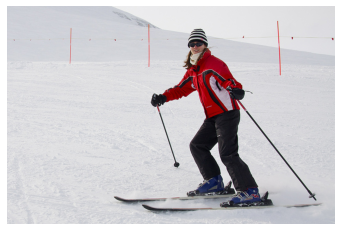

In [9]:
image = load("media/ski.jpg")
imshow(image)

### Pose Estimation inference

In [12]:
import IPython.core.debugger as db
import os
import sys
import random
import argparse
import numpy as np
import cv2 as cv

import coco
import utils
import model as modellib

class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    KEYPOINT_MASK_POOL_SIZE = 7

def run_predict(image=None, video=None):
    # Root directory of the project
    ROOT_DIR = os.getcwd()

    # Directory to save logs and trained model
    MODEL_DIR = os.path.join(ROOT_DIR, "logs")

    # Local path to trained weights file
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    if not os.path.exists(COCO_MODEL_PATH):
        raise AssertionError('please download the pre-trained model')

    inference_config = InferenceConfig()

    # Create model object in inference mode.
    db.set_trace()
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=inference_config)

    # Load weights trained on MS-COCO
    model.load_weights(COCO_MODEL_PATH, by_name=True)

    # Directory of images to run detection on
    #COCO_DIR = "images"  # TODO: enter value here
    #IMAGE_DIR = os.path.join(ROOT_DIR, "picture")

    if (image):
        if not os.path.isfile(image):
            print("Input image file ", image, " doesn't exist")
            sys.exit(1)
        cap = cv.VideoCapture(image)
        outputFile = image[:-4]+'_mask_rcnn_out_py.jpg'
    elif (video):
        if not os.path.isfile(video):
            print("Input video file ", video, " doesn't exist")
            sys.exit(1)
        cap = cv.VideoCapture(video)
        video_name = video[:-4]
        vid_out_name = f'{video_name}_mask_rcnn_out_py'
        vid_out_avi = f'{vid_out_name}.avi'
        outputFile = video[:-4]+'_mask_rcnn_out_py.avi'
    else:
        cap = cv.VideoCapture(0)

    if (video):
        vid_writer = cv.VideoWriter(outputFile,
                                    cv.VideoWriter_fourcc('M', 'J', 'P', 'G'),
                                    30,
                                    (round(cap.get(cv.CAP_PROP_FRAME_WIDTH)),
                                     round(cap.get(cv.CAP_PROP_FRAME_HEIGHT))))

    i_frames = 0
    num_frames = 140
    while (cap.isOpened()):
        hasFrame, frame = cap.read()
        if not hasFrame:
            print("Done processing !!!")
            print("Output file is stored as ", outputFile)
            #cv.waitKey(3000)
            break
        
        print("frame shape:", frame.shape)
        # class_names = ['BG', 'person']
        results = model.detect_keypoint([frame], verbose=1)
        r = results[0]
        if r['masks'].shape[0]:
          frame = display_keypoints(frame, r)

        if (image):
          cv.imwrite(outputFile, frame.astype(np.uint8))
        else:
          vid_writer.write(frame.astype(np.uint8))


        i_frames += 1
        if (i_frames > num_frames):
          cap.release()
          if (vid_out_name is not None):
            vid_writer.release()
            # convert AVI to MP4
            vid_out_mp4 = f'{vid_out_name}.mp4'
            !ffmpeg -y -loglevel info -i {vid_out_avi} {vid_out_mp4}
          break

def color_array():
    colorsFile = "colors.txt"
    with open(colorsFile, 'rt') as f:
        colorsStr = f.read().rstrip('\n').split('\n')
    colors = []
    for i in range(len(colorsStr)):
        rgb = colorsStr[i].split(' ')
        color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
        colors.append(color)
    return colors

def display_keypoints(frame, r):
            colors = color_array()
            maskThreshold = 0.3

            for i in range(r['masks'].shape[2]):
                mask = r['masks'][:, :, i]
                mask = (mask > maskThreshold)
                roi = frame[mask]
                colorIndex = random.randint(0, len(colors)-1)
                color = colors[colorIndex]
                frame[mask] = ([0.3 * color[0],
                                0.3 * color[1],
                                0.3 * color[2]] + 0.7 * roi).astype(np.uint8)
                mask = mask.astype(np.uint8)
                contours, hierarchy = cv.findContours(mask,
                                                         cv.RETR_TREE,
                                                         cv.CHAIN_APPROX_SIMPLE)
                cv.drawContours(frame, contours, -1, color, 3,
                                cv.LINE_8, hierarchy, 100)
            keypoints = np.array(r['keypoints']).astype(int)
            skeleton = [0, -1, -1, 5, -1, 6, 5, 7, 6, 8, 7, 9,
                        8, 10, 11, 13, 12, 14, 13, 15, 14, 16]
            for i in range(len(keypoints)):
                # Skeleton: 11*2
                limb_colors = [[0, 0, 255], [0, 170, 255], [0, 255, 170],
                               [0, 255, 0], [170, 255, 0], [255, 170, 0],
                               [255, 0, 0], [255, 0, 170], [170, 0, 255],
                               [170, 170, 0], [170, 0, 170]]
                if(len(skeleton)):
                    skeleton = np.reshape(skeleton, (-1, 2))
                    neck = np.array((keypoints[i, 5, :]
                                    + keypoints[i, 6, :]) / 2).astype(int)
                    if(keypoints[i, 5, 2] == 0 or keypoints[i, 6, 2] == 0):
                        neck = [0, 0, 0]
                    limb_index = -1
                    for limb in skeleton:
                        limb_index += 1
                        start_index, end_index = limb
                        if(start_index == -1):
                            Joint_start = neck
                        else:
                            Joint_start = keypoints[i][start_index]
                        if(end_index == -1):
                            Joint_end = neck
                        else:
                            Joint_end = keypoints[i][end_index]
                        if ((Joint_start[2] != 0) & (Joint_end[2] != 0)):
                            cv.line(frame,
                                    tuple(Joint_start[:2]),
                                    tuple(Joint_end[:2]),
                                    limb_colors[limb_index], 5)
                            
            return frame

### Pose Estimation on Test image

In [ ]:
run_predict(image='media/ski.jpg')
image_out = load("media/ski_mask_rcnn_out_py.jpg")
imshow(image_out)

### Old - Run via command line

In [ ]:
!python main.py --image media/ski.jpg

In [ ]:
# Run detection
results = model.detect_keypoint([image], verbose=1)
r = results[0] # for one image

log("rois",r['rois'])
log("keypoints",r['keypoints'])
log("class_ids",r['class_ids'])
log("keypoints",r['keypoints'])
log("masks",r['masks'])
log("scores",r['scores'])

visualize.display_keypoints(image,r['rois'],r['keypoints'],r['class_ids'],class_names,skeleton = inference_config.LIMBS)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

### Test Pose Estimation

In [ ]:
import os
import sys
import random
import argparse
import numpy as np
import cv2 as cv

import coco
import utils
#import model as modellib


class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    KEYPOINT_MASK_POOL_SIZE = 7


def main():
    parse = argparse.ArgumentParser()
    parse.add_argument("--image", type=str)
    parse.add_argument('--video', type=str)
    args = parse.parse_args()

def runkp(args):
    ROOT_DIR = os.getcwd()

    MODEL_DIR = os.path.join(ROOT_DIR, "logs")

    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    if not os.path.exists(COCO_MODEL_PATH):
        raise AssertionError('please download the pre-trained model')

    colorsFile = "colors.txt"
    with open(colorsFile, 'rt') as f:
        colorsStr = f.read().rstrip('\n').split('\n')
    colors = []
    for i in range(len(colorsStr)):
        rgb = colorsStr[i].split(' ')
        color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
        colors.append(color)

    inference_config = InferenceConfig()

    model = MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=inference_config)

    model.load_weights(COCO_MODEL_PATH, by_name=True)

    if (args.image):
        if not os.path.isfile(args.image):
            print("Input image file ", args.image, " doesn't exist")
            sys.exit(1)
        cap = cv.VideoCapture(args.image)
        outputFile = args.image[:-4]+'_mask_rcnn_out_py.jpg'
    elif (args.video):
        if not os.path.isfile(args.video):
            print("Input video file ", args.video, " doesn't exist")
            sys.exit(1)
        cap = cv.VideoCapture(args.video)
        outputFile = args.video[:-4]+'_mask_rcnn_out_py.avi'
    else:
        cap = cv.VideoCapture(0)

    if (not args.image):
        vid_writer = cv.VideoWriter(outputFile,
                                    cv.VideoWriter_fourcc('M', 'J', 'P', 'G'),
                                    30,
                                    (round(cap.get(cv.CAP_PROP_FRAME_WIDTH)),
                                     round(cap.get(cv.CAP_PROP_FRAME_HEIGHT))))

    maskThreshold = 0.3
    while cv.waitKey(1) < 0:
        hasFrame, frame = cap.read()
        if not hasFrame:
            print("Done processing !!!")
            print("Output file is stored as ", outputFile)
            cv.waitKey(3000)
            break
        
        print("frame shape:", frame.shape)
        # class_names = ['BG', 'person']
        results = model.detect_keypoint([frame], verbose=1)
        r = results[0]
        if r['masks'].shape[0]:
            for i in range(r['masks'].shape[2]):
                mask = r['masks'][:, :, i]
                mask = (mask > maskThreshold)
                roi = frame[mask]
                colorIndex = random.randint(0, len(colors)-1)
                color = colors[colorIndex]
                frame[mask] = ([0.3 * color[0],
                                0.3 * color[1],
                                0.3 * color[2]] + 0.7 * roi).astype(np.uint8)
                mask = mask.astype(np.uint8)
                _, contours, hierarchy = cv.findContours(mask,
                                                         cv.RETR_TREE,
                                                         cv.CHAIN_APPROX_SIMPLE)
                cv.drawContours(frame, contours, -1, color, 3,
                                cv.LINE_8, hierarchy, 100)
            keypoints = np.array(r['keypoints']).astype(int)
            skeleton = [0, -1, -1, 5, -1, 6, 5, 7, 6, 8, 7, 9,
                        8, 10, 11, 13, 12, 14, 13, 15, 14, 16]
            for i in range(len(keypoints)):
                # Skeleton: 11*2
                limb_colors = [[0, 0, 255], [0, 170, 255], [0, 255, 170],
                               [0, 255, 0], [170, 255, 0], [255, 170, 0],
                               [255, 0, 0], [255, 0, 170], [170, 0, 255],
                               [170, 170, 0], [170, 0, 170]]
                if(len(skeleton)):
                    skeleton = np.reshape(skeleton, (-1, 2))
                    neck = np.array((keypoints[i, 5, :]
                                    + keypoints[i, 6, :]) / 2).astype(int)
                    if(keypoints[i, 5, 2] == 0 or keypoints[i, 6, 2] == 0):
                        neck = [0, 0, 0]
                    limb_index = -1
                    for limb in skeleton:
                        limb_index += 1
                        start_index, end_index = limb
                        if(start_index == -1):
                            Joint_start = neck
                        else:
                            Joint_start = keypoints[i][start_index]
                        if(end_index == -1):
                            Joint_end = neck
                        else:
                            Joint_end = keypoints[i][end_index]
                        if ((Joint_start[2] != 0) & (Joint_end[2] != 0)):
                            cv.line(frame,
                                    tuple(Joint_start[:2]),
                                    tuple(Joint_end[:2]),
                                    limb_colors[limb_index], 5)
        if (args.image):
            cv.imwrite(outputFile, frame.astype(np.uint8))
        else:
            vid_writer.write(frame.astype(np.uint8))


In [ ]:
class Arg():
  def __init__(self):
    self.image='media/ski.jpg'
    self.video=None

args=Arg()
def tryit(args):
  db.set_trace()
  runkp(args)

tryit(args)